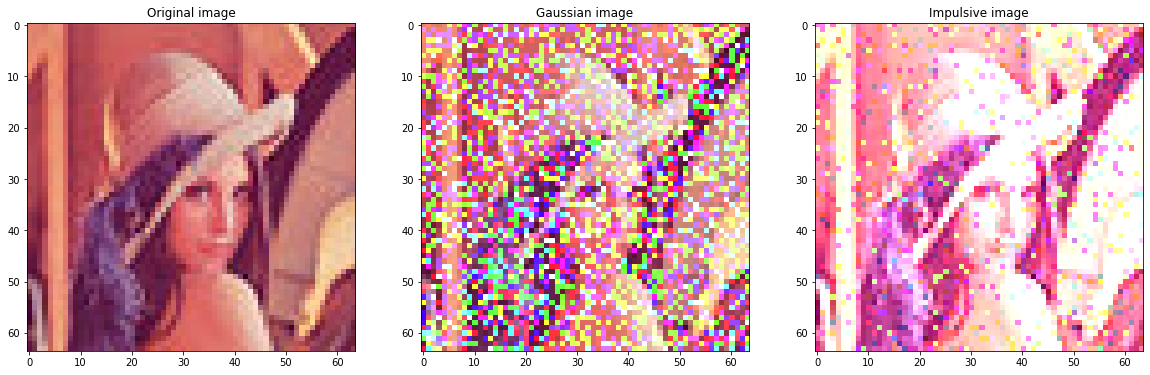

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:106: RuntimeWarning: overflow encountered in ubyte_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:131: RuntimeWarning: overflow encountered in ubyte_scalars


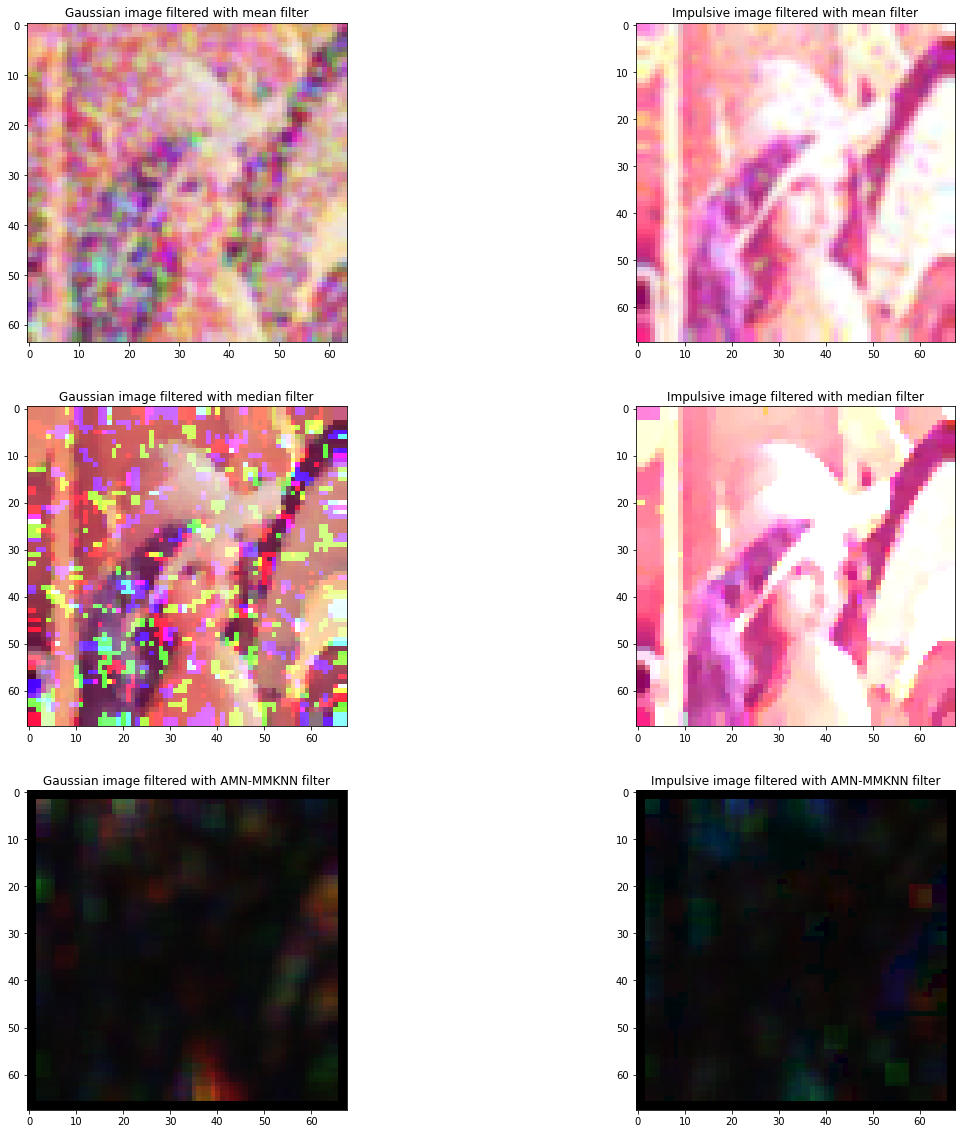

PSNR value for gaussian filtered image with mean is:  13.592437098349306
SSIM value for gaussian filtered image with mean is:  0.4584049263157212


PSNR value for impulsive filtered image with mean is:  9.744524737671975
SSIM value for impulsive filtered image with mean is:  0.5505877597028254


PSNR value for gaussian filtered image with median is:  13.276561584551116
SSIM value for gaussian filtered image with median is:  0.3847578005452798


PSNR value for impulsive filtered image with median is:  9.274934202617143
SSIM value for impulsive filtered image with median is:  0.5262517481009822


PSNR value for gaussian filtered image with AMN-MMKNN is:  6.159182975512576
SSIM value for gaussian filtered image with AMN-MMKNN is:  0.051896385233962804


PSNR value for impulsive filtered image with AMN-MMKNN is:  6.159182975512576
SSIM value for impulsive filtered image with AMN-MMKNN is:  0.051896385233962804


In [ ]:
import skimage
from skimage import io
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
from skimage.util import random_noise

# Global parameters
K_min=5
a=4
K_max=24
n=25
p=0.3
M=3

#Read images
img1 = io.imread("lena.jpg")

# Create variables for noisy images
noisy_image_gaussian = img1.copy()
noisy_image_impulsive = img1.copy()

#Create gaussian and impsulsive noise 
gaussian = np.random.normal(0,2, (img1.shape[0], img1.shape[1], img1.shape[2])).astype('uint8')
impulsive = random_noise(img1, mode='s&p',amount=0.1)
impulsive = np.array(255*impulsive, dtype = 'uint8')

# Add gaussian and impulsive noise to the image
noisy_image_gaussian = cv2.add(img1,gaussian)
noisy_image_impulsive = cv2.add(img1,impulsive)

# Create paded images for images affected by gaussian and impulsive noise
padded_noisy_image_gaussian = cv2.copyMakeBorder(noisy_image_gaussian, 2, 2, 2, 2, cv2.BORDER_REPLICATE)
padded_noisy_image_impulsive = cv2.copyMakeBorder(noisy_image_impulsive, 2, 2, 2, 2, cv2.BORDER_REPLICATE)

#Output filter image used in amn_mmknn_filter function
new_image = np.zeros(padded_noisy_image_gaussian.shape).astype(np.uint8)

### functions from https://cvnote.ddlee.cc/2019/09/12/psnr-ssim-python #########
def calculate_psnr(img1, img2):
    # img1 and img2 have range [0, 255]
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mse = np.mean((img1 - img2)**2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(255.0 / math.sqrt(mse))

def ssim(img1, img2):
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()


def calculate_ssim(img1, img2):
    '''calculate SSIM
    the same outputs as MATLAB's
    img1, img2: [0, 255]
    '''
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    if img1.ndim == 2:
        return ssim(img1, img2)
    elif img1.ndim == 3:
        if img1.shape[2] == 3:
            ssims = []
            for i in range(3):
                ssims.append(ssim(img1, img2))
            return np.array(ssims).mean()
        elif img1.shape[2] == 1:
            return ssim(np.squeeze(img1), np.squeeze(img2))
    else:
        raise ValueError('Wrong input image dimensions.')
################################################################################


def med(window, scalar=-1): #scalar = -1 => optional argument
    if scalar != -1:
        for i in range(len(window)):
            window[i] = abs(window[i] - scalar)
    window.sort()
    values = window[:]
    while len(values) != 0 and values[int(np.floor(len(values)/2))] == 0:#check to see if 0 exists in window
        values.pop(int(np.floor(len(values)/2))) # eliminate values of 0
    if len(values) != 0:# if the are non-zero elements 
        return (values[int(np.floor(len(values)/2))])#return the middle value
    else:
        return (1)
    
    
def mad(window):
    return med(window, scalar=med(window)) 
        
            
def spike_detector(window, scalar): # window = ym , scalar = y_(N+1)/2 from the article
    med_result = med(window,scalar)
    mad_result = mad(window)
    first_half = np.floor(np.divide(med_result,(mad_result)))
    second_half = np.floor(0.5*(np.divide(mad(window),med(window))))
    return first_half + second_half

def smooth_parameter(window,scalar): # window = yj , scalar = yl from the article
    suma = 0
    for i in range(len(window)):
        suma = suma + abs(window[i] - scalar)
    return n**(-p/M) * suma

def kernel_function(window, current_pixel, neighbour_pixel):
    #return math.exp(-abs(current_pixel - neighbour_pixel/smooth_parameter(window,neighbour_pixel)))
    return 1
    
def amn_mmknn_filter(image):
  for ch in range(image.shape[2]): # iterate through channels
      channel = image[:,:,ch] # get each channel of the image
      vmmknn = np.zeros(shape=channel.shape) # vmmknn values from the article
      for i in range(2, len(channel) - 2): # iterate rows
          for j in range(2, len(channel[0]) - 2): # iterate columns
              stopCond = False # break condition for while loop
              window=[] # 5x5 window array
              for length in range(i-2,i+3): 
                  for width in range(j-2,j+3):
                      window.append(channel[length][width]) # get neighbours pixels of current pixel
              idx = 12 # y_(N+1)/2 from article
              idx_list = [] # store the past indexes from which we iterated through 
              counter = 0 # know how many times the while loop is executed
              while stopCond == False: # while eˆVMMKNN(q) != eˆVMMKNN(q+1)
                  Kc_dict = {} # key = index , value = result of the number of the nearest neighbour pixels
                  e_dict = {} # key = eˆVMMKNN(q) , value = number of the nearest neighbour pixels for eˆVMMKNN(q)
                  e_index = idx # eˆVMMKNN(q)
                  for k in range(len(window)): # iterate through window pixels
                      result = K_min + a * spike_detector(window,window[k]) # Kc from the article for each pixel from the window
                      if k == e_index: # check if pixel index is the same as eˆVMMKNN(q)
                          e_dict[e_index] = result 
                      elif result <= K_max: # check if result for pixel index is smaller than Kmax
                          Kc_dict[k] = result
                  diff_dict = {} # dictionary for the differences between the Kc values
                  for key in Kc_dict.keys(): 
                      diff = abs(Kc_dict[key] - e_dict[e_index])
                      diff_dict[key] = diff
                  diff_dict = dict(sorted(diff_dict.items(), key=lambda item: item[1])) # sort dictionary by values
                  idx = int(len(diff_dict)/2) # get central index of difference dictionary
                  counter += 1                  
                  if idx == e_index or e_index in idx_list: # check if eˆVMMKNN(q) = eˆVMMKNN(q+1)
                      stopCond = True
                  idx_list.append(idx)
              vmmknn[i][j] = e_dict[e_index]       
      filter_output = np.zeros(shape=channel.shape).astype(np.uint8) # filtered image
      for i in range(2, len(channel) - 2): # iterate rows
          for j in range(2, len(channel[0]) - 2): # iterate columns
              vmmknn_window = [] # vmmknn for the valid pixels(non-padded pixels)
              window = [] # valid neighbour pixels
              for length in range(i-2,i+3): 
                  for width in range(j-2,j+3):
                      if length >= 2 and length <= len(channel) - 3: # check for valid pixels
                          if width >= 2 and width <= len(channel[0]) - 3:
                              vmmknn_window.append(vmmknn[length][width]) 
                              window.append(channel[length][width])
              ###### Compute the (1) equation from the article######
              filter_out = 0 
              result_jos = 0
              for l2 in range(len(window)):
                result_jos = result_jos + smooth_parameter(window,window[l2]) * kernel_function(window, channel[i][j], window[l2])
                if result_jos == 0:
                  result_jos += 0.1
                #print(result_jos)
              for l1 in range(len(window)):
                filter_out = filter_out + vmmknn_window[l1] * (smooth_parameter(window, window[l1]) * kernel_function(window, channel[i][j], window[l1])) / result_jos
              filter_output[i][j] = int(filter_out)
              ##########################################################
      new_image[:,:,ch] = filter_output # filter for each channel
  return new_image


#Plot original + gaussian + impulsive images
fig = plt.figure(figsize=(20, 20))

ax1 = fig.add_subplot(1,3,1)
ax1.imshow(img1)
ax1.title.set_text('Original image')

ax2 = fig.add_subplot(1,3,2)
ax2.imshow(noisy_image_gaussian)
ax2.title.set_text('Gaussian image')

ax3 = fig.add_subplot(1,3,3)
ax3.imshow(noisy_image_impulsive)
ax3.title.set_text('Impulsive image')

plt.show()


# Plot the filtered images

fig = plt.figure(figsize=(20, 20))

ax1 = fig.add_subplot(3,2,1)
ax1.imshow(cv2.GaussianBlur(noisy_image_gaussian,(3,3),0,cv2.BORDER_CONSTANT))
ax1.title.set_text('Gaussian image filtered with mean filter')

ax2 = fig.add_subplot(3,2,2)
ax2.imshow(cv2.GaussianBlur(padded_noisy_image_impulsive,(3,3),0,cv2.BORDER_CONSTANT))
ax2.title.set_text('Impulsive image filtered with mean filter')

ax3 = fig.add_subplot(3,2,3)
ax3.imshow(cv2.medianBlur(padded_noisy_image_gaussian, 3))
ax3.title.set_text('Gaussian image filtered with median filter')

ax4 = fig.add_subplot(3,2,4)
ax4.imshow(cv2.medianBlur(padded_noisy_image_impulsive, 3))
ax4.title.set_text('Impulsive image filtered with median filter')

ax5 = fig.add_subplot(3,2,5)
ax5.imshow(amn_mmknn_filter(padded_noisy_image_gaussian))
ax5.title.set_text('Gaussian image filtered with AMN-MMKNN filter')

ax6 = fig.add_subplot(3,2,6)
ax6.imshow(amn_mmknn_filter(padded_noisy_image_impulsive))
ax6.title.set_text('Impulsive image filtered with AMN-MMKNN filter')

plt.show()


#Padded original image used to calculate PSNR and SSIM for image with gaussian noise
original_image = cv2.copyMakeBorder(img1, 2, 2, 2, 2, cv2.BORDER_REPLICATE)

print('PSNR value for gaussian filtered image with mean is: ', calculate_psnr(original_image, cv2.GaussianBlur(padded_noisy_image_gaussian,(3,3),0,cv2.BORDER_CONSTANT)))
print('SSIM value for gaussian filtered image with mean is: ', calculate_ssim(original_image, cv2.GaussianBlur(padded_noisy_image_gaussian,(3,3),0,cv2.BORDER_CONSTANT)))
print('\n')

print('PSNR value for impulsive filtered image with mean is: ', calculate_psnr(original_image, cv2.GaussianBlur(padded_noisy_image_impulsive,(3,3),0,cv2.BORDER_CONSTANT)))
print('SSIM value for impulsive filtered image with mean is: ', calculate_ssim(original_image, cv2.GaussianBlur(padded_noisy_image_impulsive,(3,3),0,cv2.BORDER_CONSTANT)))
print('\n')

print('PSNR value for gaussian filtered image with median is: ', calculate_psnr(original_image, cv2.medianBlur(padded_noisy_image_gaussian, 3)))
print('SSIM value for gaussian filtered image with median is: ', calculate_ssim(original_image, cv2.medianBlur(padded_noisy_image_gaussian, 3)))
print('\n')

print('PSNR value for impulsive filtered image with median is: ', calculate_psnr(original_image, cv2.medianBlur(padded_noisy_image_impulsive, 3)))
print('SSIM value for impulsive filtered image with median is: ', calculate_ssim(original_image, cv2.medianBlur(padded_noisy_image_impulsive, 3)))
print('\n')


print('PSNR value for gaussian filtered image with AMN-MMKNN is: ', calculate_psnr(original_image, amn_mmknn_filter(padded_noisy_image_gaussian)))
print('SSIM value for gaussian filtered image with AMN-MMKNN is: ', calculate_ssim(original_image, amn_mmknn_filter(padded_noisy_image_gaussian)))
print('\n')

print('PSNR value for impulsive filtered image with AMN-MMKNN is: ', calculate_psnr(original_image, amn_mmknn_filter(padded_noisy_image_gaussian)))
print('SSIM value for impulsive filtered image with AMN-MMKNN is: ', calculate_ssim(original_image, amn_mmknn_filter(padded_noisy_image_gaussian)))

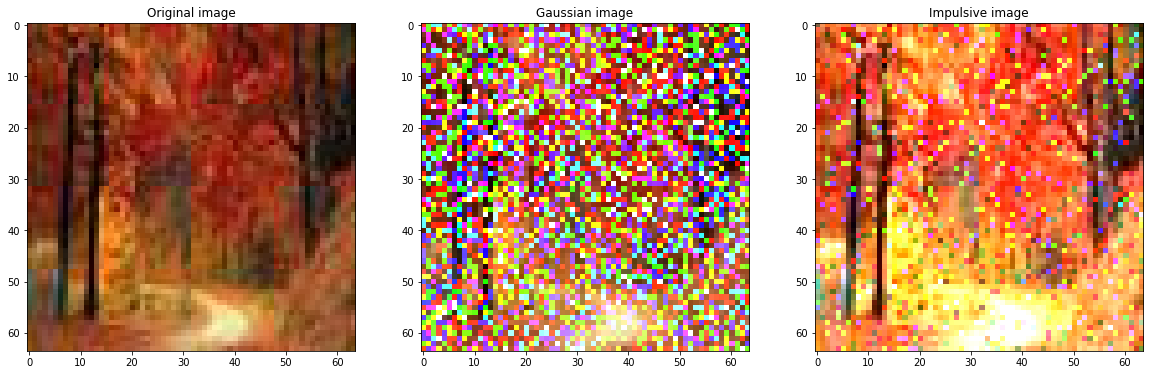

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:106: RuntimeWarning: overflow encountered in ubyte_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:131: RuntimeWarning: overflow encountered in ubyte_scalars


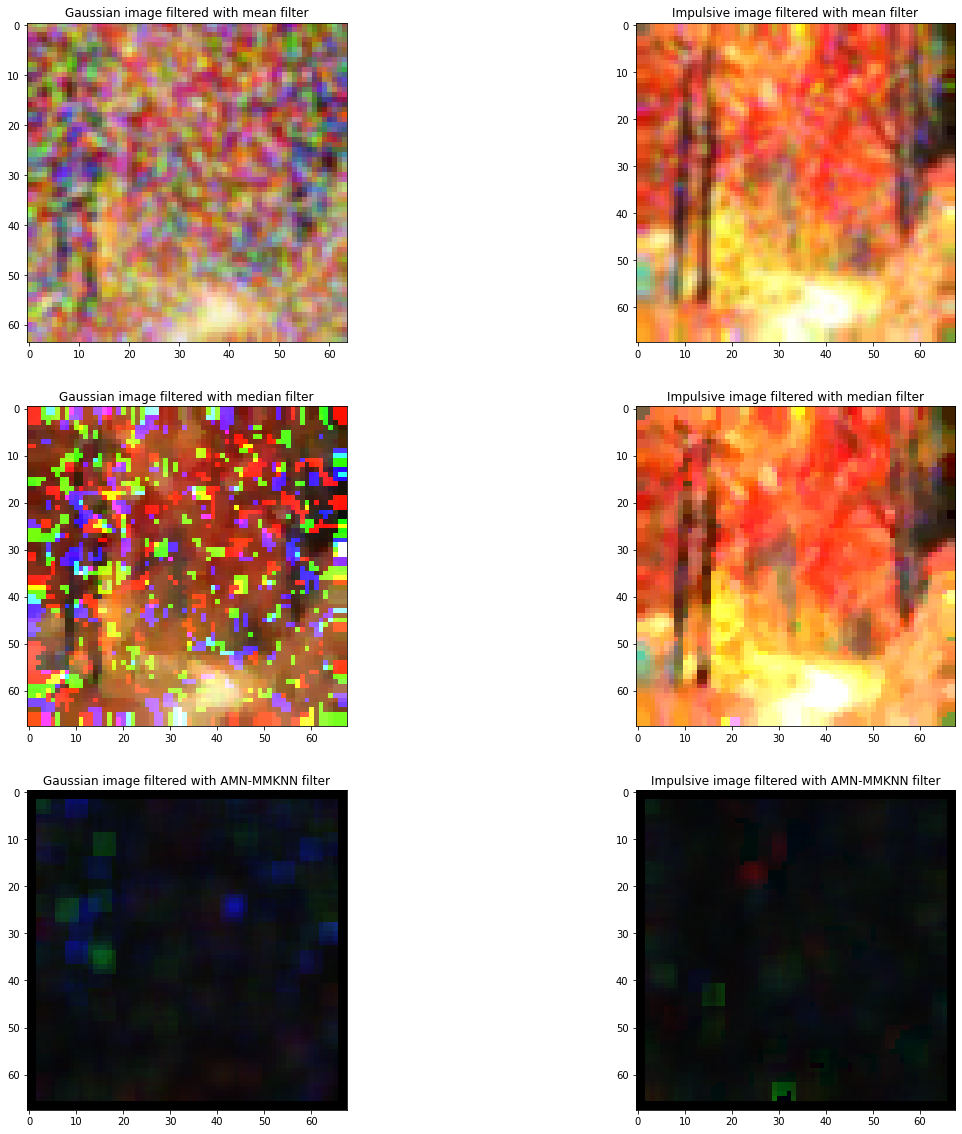

PSNR value for gaussian filtered image with mean is:  11.277935259386954
SSIM value for gaussian filtered image with mean is:  0.25507721739552675


PSNR value for impulsive filtered image with mean is:  11.135304948288223
SSIM value for impulsive filtered image with mean is:  0.5212188240856317


PSNR value for gaussian filtered image with median is:  11.367018892132839
SSIM value for gaussian filtered image with median is:  0.25231202452385804


PSNR value for impulsive filtered image with median is:  10.951576376867077
SSIM value for impulsive filtered image with median is:  0.5116878172391476


PSNR value for gaussian filtered image with AMN-MMKNN is:  9.383164722504262
SSIM value for gaussian filtered image with AMN-MMKNN is:  0.08003690345193736


PSNR value for impulsive filtered image with AMN-MMKNN is:  9.383164722504262
SSIM value for impulsive filtered image with AMN-MMKNN is:  0.08003690345193736


In [ ]:
img2 = io.imread("img2.jpg")

noisy_image_gaussian = img2.copy()
noisy_image_impulsive = img2.copy()

#Create gaussian and impsulsive noise 
gaussian = np.random.normal(0,2, (img2.shape[0], img2.shape[1], img2.shape[2])).astype('uint8')
impulsive = random_noise(img2, mode='s&p',amount=0.1)
impulsive = np.array(255*impulsive, dtype = 'uint8')

# Add gaussian and impulsive noise to the image
noisy_image_gaussian = cv2.add(img2,gaussian)
noisy_image_impulsive = cv2.add(img2,impulsive)

# Create paded images for images affected by gaussian and impulsive noise
padded_noisy_image_gaussian = cv2.copyMakeBorder(noisy_image_gaussian, 2, 2, 2, 2, cv2.BORDER_REPLICATE)
padded_noisy_image_impulsive = cv2.copyMakeBorder(noisy_image_impulsive, 2, 2, 2, 2, cv2.BORDER_REPLICATE)

#Output filter image used in amn_mmknn_filter function
new_image = np.zeros(padded_noisy_image_gaussian.shape).astype(np.uint8)

#Plot original + gaussian + impulsive images
fig = plt.figure(figsize=(20, 20))

ax1 = fig.add_subplot(1,3,1)
ax1.imshow(img2)
ax1.title.set_text('Original image')

ax2 = fig.add_subplot(1,3,2)
ax2.imshow(noisy_image_gaussian)
ax2.title.set_text('Gaussian image')

ax3 = fig.add_subplot(1,3,3)
ax3.imshow(noisy_image_impulsive)
ax3.title.set_text('Impulsive image')

plt.show()


# Plot the filtered images

fig = plt.figure(figsize=(20, 20))

ax1 = fig.add_subplot(3,2,1)
ax1.imshow(cv2.GaussianBlur(noisy_image_gaussian,(3,3),0,cv2.BORDER_CONSTANT))
ax1.title.set_text('Gaussian image filtered with mean filter')

ax2 = fig.add_subplot(3,2,2)
ax2.imshow(cv2.GaussianBlur(padded_noisy_image_impulsive,(3,3),0,cv2.BORDER_CONSTANT))
ax2.title.set_text('Impulsive image filtered with mean filter')

ax3 = fig.add_subplot(3,2,3)
ax3.imshow(cv2.medianBlur(padded_noisy_image_gaussian, 3))
ax3.title.set_text('Gaussian image filtered with median filter')

ax4 = fig.add_subplot(3,2,4)
ax4.imshow(cv2.medianBlur(padded_noisy_image_impulsive, 3))
ax4.title.set_text('Impulsive image filtered with median filter')

ax5 = fig.add_subplot(3,2,5)
ax5.imshow(amn_mmknn_filter(padded_noisy_image_gaussian))
ax5.title.set_text('Gaussian image filtered with AMN-MMKNN filter')

ax6 = fig.add_subplot(3,2,6)
ax6.imshow(amn_mmknn_filter(padded_noisy_image_impulsive))
ax6.title.set_text('Impulsive image filtered with AMN-MMKNN filter')

plt.show()


#Padded original image used to calculate PSNR and SSIM for image with gaussian noise
original_image = cv2.copyMakeBorder(img2, 2, 2, 2, 2, cv2.BORDER_REPLICATE)

print('PSNR value for gaussian filtered image with mean is: ', calculate_psnr(original_image, cv2.GaussianBlur(padded_noisy_image_gaussian,(3,3),0,cv2.BORDER_CONSTANT)))
print('SSIM value for gaussian filtered image with mean is: ', calculate_ssim(original_image, cv2.GaussianBlur(padded_noisy_image_gaussian,(3,3),0,cv2.BORDER_CONSTANT)))
print('\n')

print('PSNR value for impulsive filtered image with mean is: ', calculate_psnr(original_image, cv2.GaussianBlur(padded_noisy_image_impulsive,(3,3),0,cv2.BORDER_CONSTANT)))
print('SSIM value for impulsive filtered image with mean is: ', calculate_ssim(original_image, cv2.GaussianBlur(padded_noisy_image_impulsive,(3,3),0,cv2.BORDER_CONSTANT)))
print('\n')

print('PSNR value for gaussian filtered image with median is: ', calculate_psnr(original_image, cv2.medianBlur(padded_noisy_image_gaussian, 3)))
print('SSIM value for gaussian filtered image with median is: ', calculate_ssim(original_image, cv2.medianBlur(padded_noisy_image_gaussian, 3)))
print('\n')

print('PSNR value for impulsive filtered image with median is: ', calculate_psnr(original_image, cv2.medianBlur(padded_noisy_image_impulsive, 3)))
print('SSIM value for impulsive filtered image with median is: ', calculate_ssim(original_image, cv2.medianBlur(padded_noisy_image_impulsive, 3)))
print('\n')


print('PSNR value for gaussian filtered image with AMN-MMKNN is: ', calculate_psnr(original_image, amn_mmknn_filter(padded_noisy_image_gaussian)))
print('SSIM value for gaussian filtered image with AMN-MMKNN is: ', calculate_ssim(original_image, amn_mmknn_filter(padded_noisy_image_gaussian)))
print('\n')

print('PSNR value for impulsive filtered image with AMN-MMKNN is: ', calculate_psnr(original_image, amn_mmknn_filter(padded_noisy_image_gaussian)))
print('SSIM value for impulsive filtered image with AMN-MMKNN is: ', calculate_ssim(original_image, amn_mmknn_filter(padded_noisy_image_gaussian)))

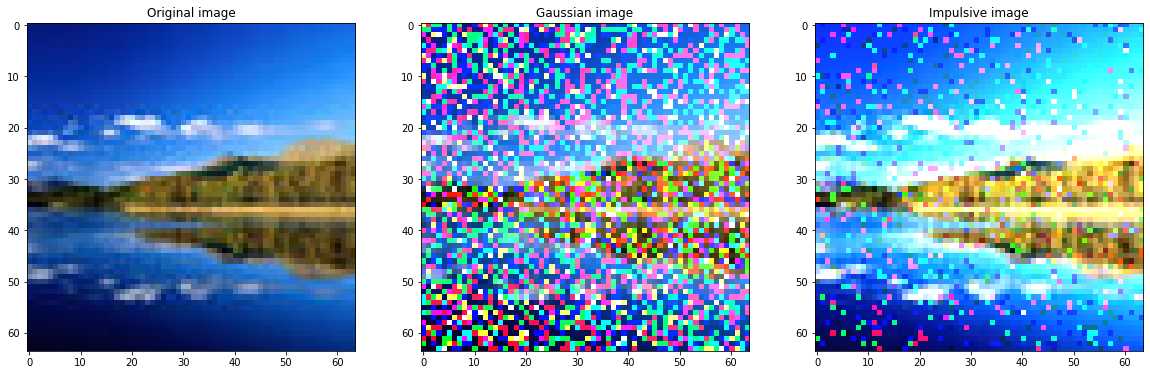

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:106: RuntimeWarning: overflow encountered in ubyte_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:131: RuntimeWarning: overflow encountered in ubyte_scalars


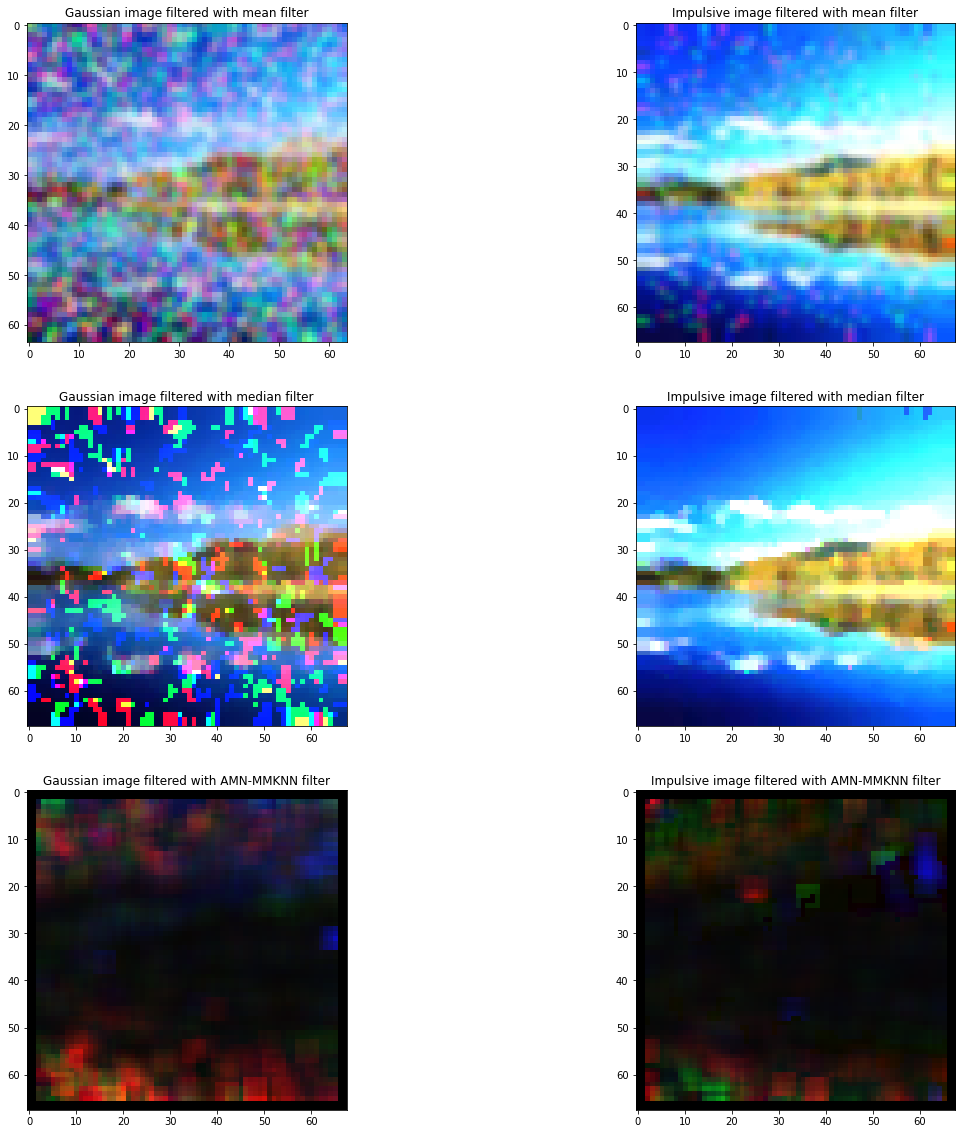

PSNR value for gaussian filtered image with mean is:  11.891060851693169
SSIM value for gaussian filtered image with mean is:  0.38340770802851765


PSNR value for impulsive filtered image with mean is:  11.159137692047182
SSIM value for impulsive filtered image with mean is:  0.5324586839511024


PSNR value for gaussian filtered image with median is:  11.935173516116704
SSIM value for gaussian filtered image with median is:  0.37427048722868483


PSNR value for impulsive filtered image with median is:  11.067960160509305
SSIM value for impulsive filtered image with median is:  0.6022305783904056


PSNR value for gaussian filtered image with AMN-MMKNN is:  7.683936224474554
SSIM value for gaussian filtered image with AMN-MMKNN is:  0.044801900854979544


PSNR value for impulsive filtered image with AMN-MMKNN is:  7.683936224474554
SSIM value for impulsive filtered image with AMN-MMKNN is:  0.044801900854979544


In [ ]:
img3 = io.imread("img3.jpg")

noisy_image_gaussian = img3.copy()
noisy_image_impulsive = img3.copy()

#Create gaussian and impsulsive noise 
gaussian = np.random.normal(0,2, (img3.shape[0], img3.shape[1], img3.shape[2])).astype('uint8')
impulsive = random_noise(img3, mode='s&p',amount=0.1)
impulsive = np.array(255*impulsive, dtype = 'uint8')

# Add gaussian and impulsive noise to the image
noisy_image_gaussian = cv2.add(img3,gaussian)
noisy_image_impulsive = cv2.add(img3,impulsive)

# Create paded images for images affected by gaussian and impulsive noise
padded_noisy_image_gaussian = cv2.copyMakeBorder(noisy_image_gaussian, 2, 2, 2, 2, cv2.BORDER_REPLICATE)
padded_noisy_image_impulsive = cv2.copyMakeBorder(noisy_image_impulsive, 2, 2, 2, 2, cv2.BORDER_REPLICATE)

#Output filter image used in amn_mmknn_filter function
new_image = np.zeros(padded_noisy_image_gaussian.shape).astype(np.uint8)

#Plot original + gaussian + impulsive images
fig = plt.figure(figsize=(20, 20))

ax1 = fig.add_subplot(1,3,1)
ax1.imshow(img3)
ax1.title.set_text('Original image')

ax2 = fig.add_subplot(1,3,2)
ax2.imshow(noisy_image_gaussian)
ax2.title.set_text('Gaussian image')

ax3 = fig.add_subplot(1,3,3)
ax3.imshow(noisy_image_impulsive)
ax3.title.set_text('Impulsive image')

plt.show()


# Plot the filtered images

fig = plt.figure(figsize=(20, 20))

ax1 = fig.add_subplot(3,2,1)
ax1.imshow(cv2.GaussianBlur(noisy_image_gaussian,(3,3),0,cv2.BORDER_CONSTANT))
ax1.title.set_text('Gaussian image filtered with mean filter')

ax2 = fig.add_subplot(3,2,2)
ax2.imshow(cv2.GaussianBlur(padded_noisy_image_impulsive,(3,3),0,cv2.BORDER_CONSTANT))
ax2.title.set_text('Impulsive image filtered with mean filter')

ax3 = fig.add_subplot(3,2,3)
ax3.imshow(cv2.medianBlur(padded_noisy_image_gaussian, 3))
ax3.title.set_text('Gaussian image filtered with median filter')

ax4 = fig.add_subplot(3,2,4)
ax4.imshow(cv2.medianBlur(padded_noisy_image_impulsive, 3))
ax4.title.set_text('Impulsive image filtered with median filter')

ax5 = fig.add_subplot(3,2,5)
ax5.imshow(amn_mmknn_filter(padded_noisy_image_gaussian))
ax5.title.set_text('Gaussian image filtered with AMN-MMKNN filter')

ax6 = fig.add_subplot(3,2,6)
ax6.imshow(amn_mmknn_filter(padded_noisy_image_impulsive))
ax6.title.set_text('Impulsive image filtered with AMN-MMKNN filter')

plt.show() 


#Padded original image used to calculate PSNR and SSIM for image with gaussian noise
original_image = cv2.copyMakeBorder(img3, 2, 2, 2, 2, cv2.BORDER_REPLICATE)

print('PSNR value for gaussian filtered image with mean is: ', calculate_psnr(original_image, cv2.GaussianBlur(padded_noisy_image_gaussian,(3,3),0,cv2.BORDER_CONSTANT)))
print('SSIM value for gaussian filtered image with mean is: ', calculate_ssim(original_image, cv2.GaussianBlur(padded_noisy_image_gaussian,(3,3),0,cv2.BORDER_CONSTANT)))
print('\n')

print('PSNR value for impulsive filtered image with mean is: ', calculate_psnr(original_image, cv2.GaussianBlur(padded_noisy_image_impulsive,(3,3),0,cv2.BORDER_CONSTANT)))
print('SSIM value for impulsive filtered image with mean is: ', calculate_ssim(original_image, cv2.GaussianBlur(padded_noisy_image_impulsive,(3,3),0,cv2.BORDER_CONSTANT)))
print('\n')

print('PSNR value for gaussian filtered image with median is: ', calculate_psnr(original_image, cv2.medianBlur(padded_noisy_image_gaussian, 3)))
print('SSIM value for gaussian filtered image with median is: ', calculate_ssim(original_image, cv2.medianBlur(padded_noisy_image_gaussian, 3)))
print('\n')

print('PSNR value for impulsive filtered image with median is: ', calculate_psnr(original_image, cv2.medianBlur(padded_noisy_image_impulsive, 3)))
print('SSIM value for impulsive filtered image with median is: ', calculate_ssim(original_image, cv2.medianBlur(padded_noisy_image_impulsive, 3)))
print('\n')


print('PSNR value for gaussian filtered image with AMN-MMKNN is: ', calculate_psnr(original_image, amn_mmknn_filter(padded_noisy_image_gaussian)))
print('SSIM value for gaussian filtered image with AMN-MMKNN is: ', calculate_ssim(original_image, amn_mmknn_filter(padded_noisy_image_gaussian)))
print('\n')

print('PSNR value for impulsive filtered image with AMN-MMKNN is: ', calculate_psnr(original_image, amn_mmknn_filter(padded_noisy_image_gaussian)))
print('SSIM value for impulsive filtered image with AMN-MMKNN is: ', calculate_ssim(original_image, amn_mmknn_filter(padded_noisy_image_gaussian)))

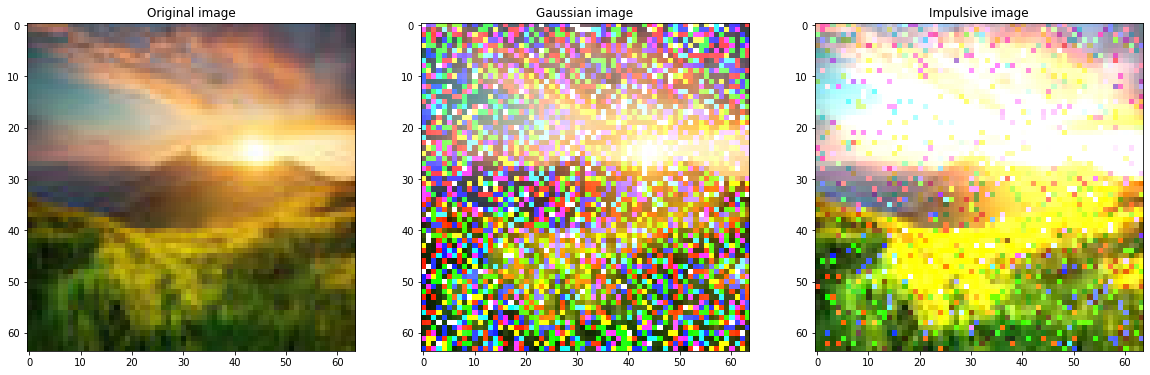

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:106: RuntimeWarning: overflow encountered in ubyte_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:131: RuntimeWarning: overflow encountered in ubyte_scalars


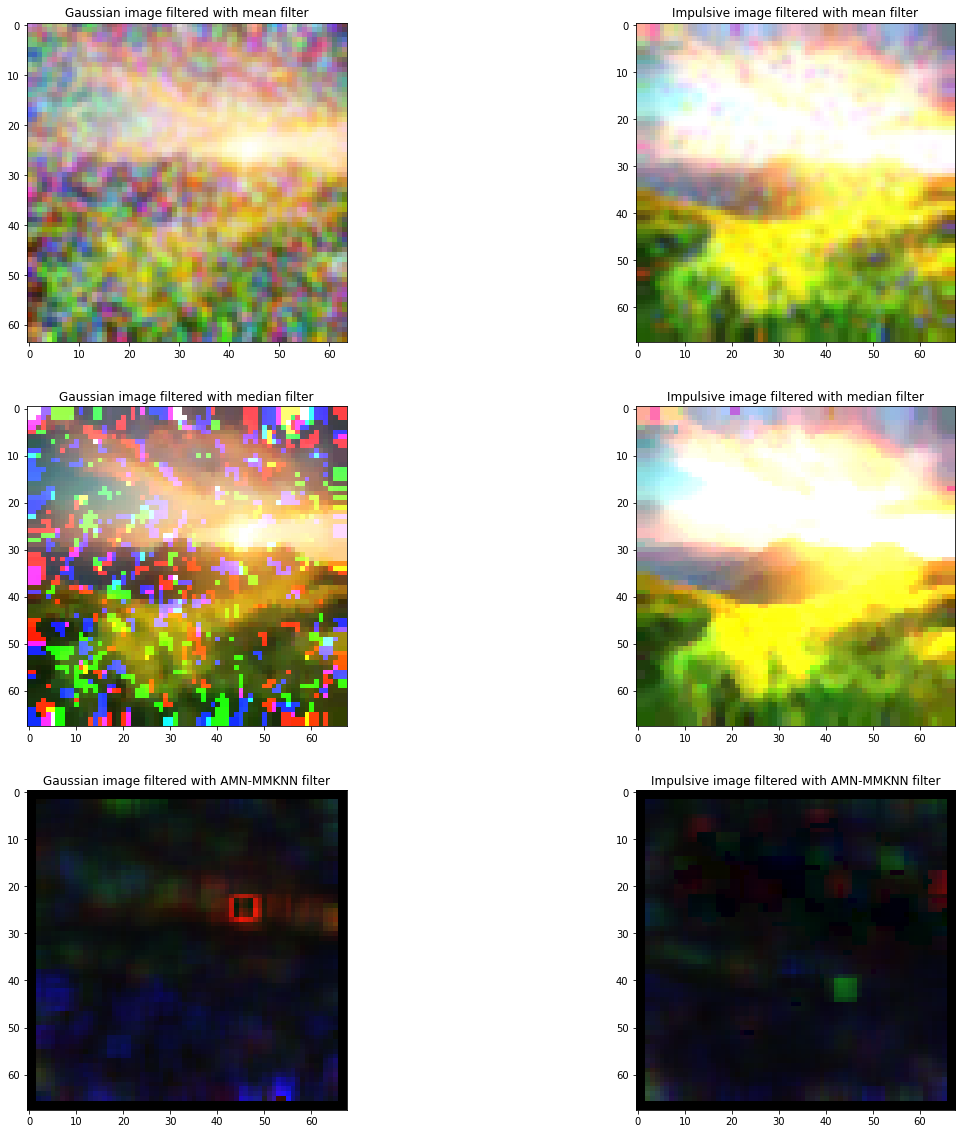

PSNR value for gaussian filtered image with mean is:  12.317269663245868
SSIM value for gaussian filtered image with mean is:  0.3959226835065756


PSNR value for impulsive filtered image with mean is:  10.355494581906207
SSIM value for impulsive filtered image with mean is:  0.4919638206388203


PSNR value for gaussian filtered image with median is:  12.46258481876283
SSIM value for gaussian filtered image with median is:  0.39297462085910984


PSNR value for impulsive filtered image with median is:  10.202918764782204
SSIM value for impulsive filtered image with median is:  0.5198268865052373


PSNR value for gaussian filtered image with AMN-MMKNN is:  7.526417730917516
SSIM value for gaussian filtered image with AMN-MMKNN is:  0.07628927121471292


PSNR value for impulsive filtered image with AMN-MMKNN is:  7.526417730917516
SSIM value for impulsive filtered image with AMN-MMKNN is:  0.07628927121471292


In [ ]:
img4 = io.imread("img4.jpg")

noisy_image_gaussian = img4.copy()
noisy_image_impulsive = img4.copy()

#Create gaussian and impsulsive noise 
gaussian = np.random.normal(0,2, (img4.shape[0], img4.shape[1], img4.shape[2])).astype('uint8')
impulsive = random_noise(img4, mode='s&p',amount=0.1)
impulsive = np.array(255*impulsive, dtype = 'uint8')

# Add gaussian and impulsive noise to the image
noisy_image_gaussian = cv2.add(img4,gaussian)
noisy_image_impulsive = cv2.add(img4,impulsive)

# Create paded images for images affected by gaussian and impulsive noise
padded_noisy_image_gaussian = cv2.copyMakeBorder(noisy_image_gaussian, 2, 2, 2, 2, cv2.BORDER_REPLICATE)
padded_noisy_image_impulsive = cv2.copyMakeBorder(noisy_image_impulsive, 2, 2, 2, 2, cv2.BORDER_REPLICATE)

#Output filter image used in amn_mmknn_filter function
new_image = np.zeros(padded_noisy_image_gaussian.shape).astype(np.uint8)

#Plot original + gaussian + impulsive images
fig = plt.figure(figsize=(20, 20))

ax1 = fig.add_subplot(1,3,1)
ax1.imshow(img4)
ax1.title.set_text('Original image')

ax2 = fig.add_subplot(1,3,2)
ax2.imshow(noisy_image_gaussian)
ax2.title.set_text('Gaussian image')

ax3 = fig.add_subplot(1,3,3)
ax3.imshow(noisy_image_impulsive)
ax3.title.set_text('Impulsive image')

plt.show()


# Plot the filtered images

fig = plt.figure(figsize=(20, 20))

ax1 = fig.add_subplot(3,2,1)
ax1.imshow(cv2.GaussianBlur(noisy_image_gaussian,(3,3),0,cv2.BORDER_CONSTANT))
ax1.title.set_text('Gaussian image filtered with mean filter')

ax2 = fig.add_subplot(3,2,2)
ax2.imshow(cv2.GaussianBlur(padded_noisy_image_impulsive,(3,3),0,cv2.BORDER_CONSTANT))
ax2.title.set_text('Impulsive image filtered with mean filter')

ax3 = fig.add_subplot(3,2,3)
ax3.imshow(cv2.medianBlur(padded_noisy_image_gaussian, 3))
ax3.title.set_text('Gaussian image filtered with median filter')

ax4 = fig.add_subplot(3,2,4)
ax4.imshow(cv2.medianBlur(padded_noisy_image_impulsive, 3))
ax4.title.set_text('Impulsive image filtered with median filter')

ax5 = fig.add_subplot(3,2,5)
ax5.imshow(amn_mmknn_filter(padded_noisy_image_gaussian))
ax5.title.set_text('Gaussian image filtered with AMN-MMKNN filter')

ax6 = fig.add_subplot(3,2,6)
ax6.imshow(amn_mmknn_filter(padded_noisy_image_impulsive))
ax6.title.set_text('Impulsive image filtered with AMN-MMKNN filter')

plt.show()


#Padded original image used to calculate PSNR and SSIM for image with gaussian noise
original_image = cv2.copyMakeBorder(img4, 2, 2, 2, 2, cv2.BORDER_REPLICATE)

print('PSNR value for gaussian filtered image with mean is: ', calculate_psnr(original_image, cv2.GaussianBlur(padded_noisy_image_gaussian,(3,3),0,cv2.BORDER_CONSTANT)))
print('SSIM value for gaussian filtered image with mean is: ', calculate_ssim(original_image, cv2.GaussianBlur(padded_noisy_image_gaussian,(3,3),0,cv2.BORDER_CONSTANT)))
print('\n')

print('PSNR value for impulsive filtered image with mean is: ', calculate_psnr(original_image, cv2.GaussianBlur(padded_noisy_image_impulsive,(3,3),0,cv2.BORDER_CONSTANT)))
print('SSIM value for impulsive filtered image with mean is: ', calculate_ssim(original_image, cv2.GaussianBlur(padded_noisy_image_impulsive,(3,3),0,cv2.BORDER_CONSTANT)))
print('\n')

print('PSNR value for gaussian filtered image with median is: ', calculate_psnr(original_image, cv2.medianBlur(padded_noisy_image_gaussian, 3)))
print('SSIM value for gaussian filtered image with median is: ', calculate_ssim(original_image, cv2.medianBlur(padded_noisy_image_gaussian, 3)))
print('\n')

print('PSNR value for impulsive filtered image with median is: ', calculate_psnr(original_image, cv2.medianBlur(padded_noisy_image_impulsive, 3)))
print('SSIM value for impulsive filtered image with median is: ', calculate_ssim(original_image, cv2.medianBlur(padded_noisy_image_impulsive, 3)))
print('\n')


print('PSNR value for gaussian filtered image with AMN-MMKNN is: ', calculate_psnr(original_image, amn_mmknn_filter(padded_noisy_image_gaussian)))
print('SSIM value for gaussian filtered image with AMN-MMKNN is: ', calculate_ssim(original_image, amn_mmknn_filter(padded_noisy_image_gaussian)))
print('\n')

print('PSNR value for impulsive filtered image with AMN-MMKNN is: ', calculate_psnr(original_image, amn_mmknn_filter(padded_noisy_image_gaussian)))
print('SSIM value for impulsive filtered image with AMN-MMKNN is: ', calculate_ssim(original_image, amn_mmknn_filter(padded_noisy_image_gaussian)))

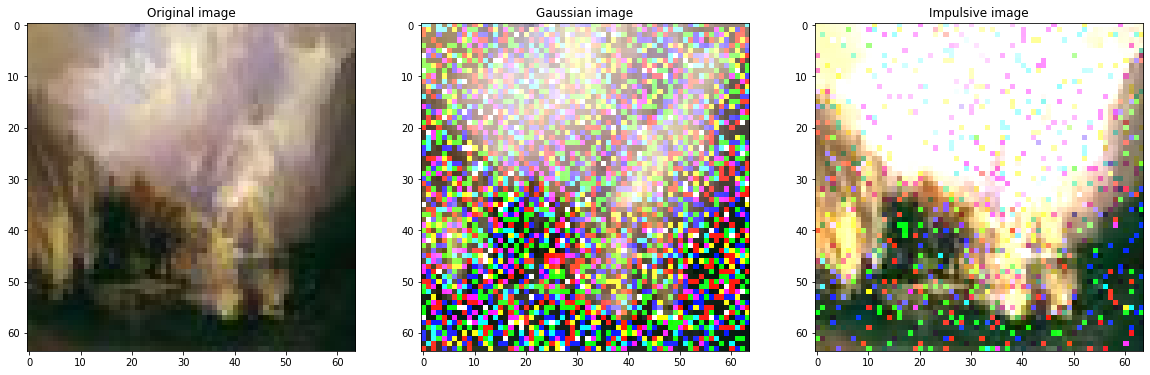

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:106: RuntimeWarning: overflow encountered in ubyte_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:131: RuntimeWarning: overflow encountered in ubyte_scalars


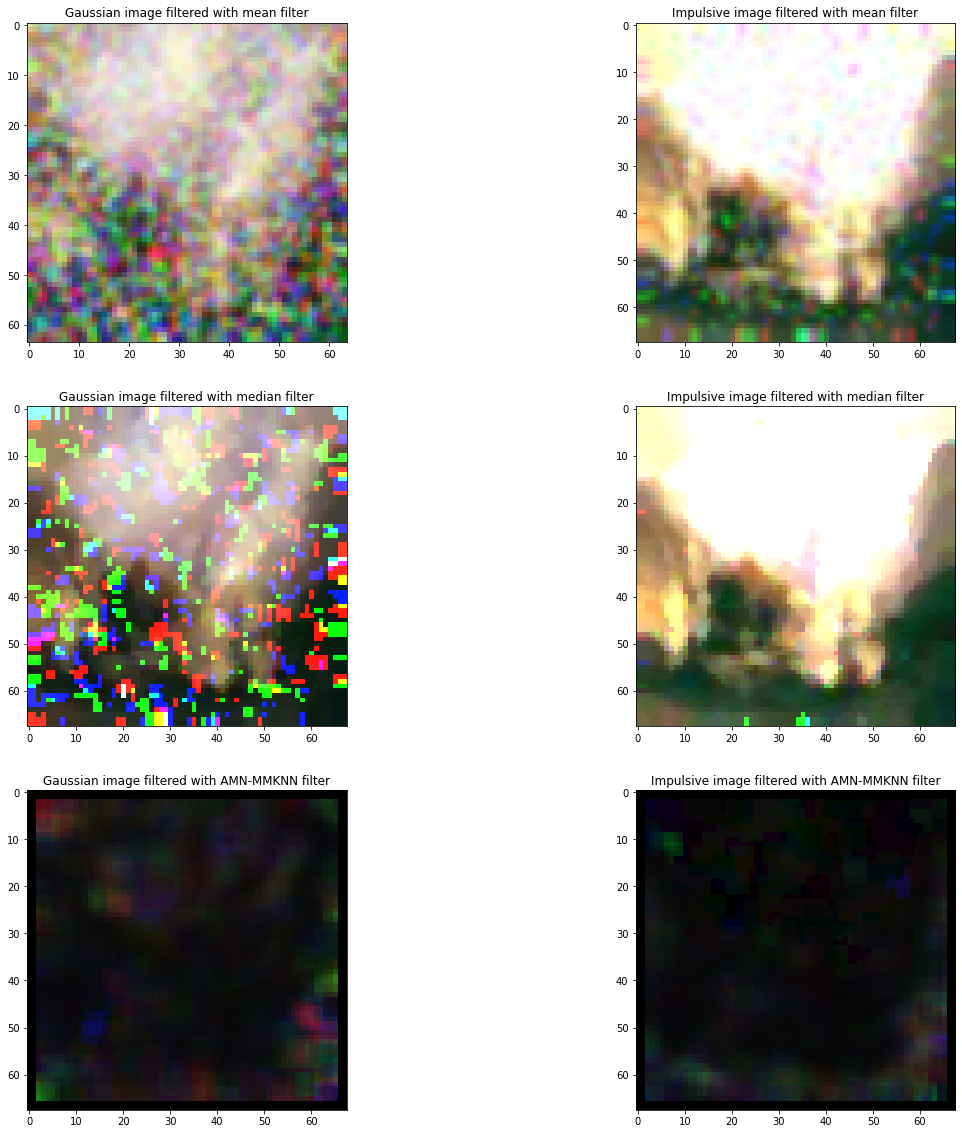

PSNR value for gaussian filtered image with mean is:  12.53656446473995
SSIM value for gaussian filtered image with mean is:  0.3820794648060204


PSNR value for impulsive filtered image with mean is:  10.730772447498353
SSIM value for impulsive filtered image with mean is:  0.4740328828616039


PSNR value for gaussian filtered image with median is:  12.93101995261555
SSIM value for gaussian filtered image with median is:  0.37446903721548885


PSNR value for impulsive filtered image with median is:  10.659357494796538
SSIM value for impulsive filtered image with median is:  0.5144027489445495


PSNR value for gaussian filtered image with AMN-MMKNN is:  7.511767750724566
SSIM value for gaussian filtered image with AMN-MMKNN is:  0.07820416764484843


PSNR value for impulsive filtered image with AMN-MMKNN is:  7.511767750724566
SSIM value for impulsive filtered image with AMN-MMKNN is:  0.07820416764484843


In [ ]:
img5 = io.imread("img5.jpg")

noisy_image_gaussian = img5.copy()
noisy_image_impulsive = img5.copy()

#Create gaussian and impsulsive noise 
gaussian = np.random.normal(0,2, (img5.shape[0], img5.shape[1], img5.shape[2])).astype('uint8')
impulsive = random_noise(img5, mode='s&p',amount=0.1)
impulsive = np.array(255*impulsive, dtype = 'uint8')

# Add gaussian and impulsive noise to the image
noisy_image_gaussian = cv2.add(img5,gaussian)
noisy_image_impulsive = cv2.add(img5,impulsive)

# Create paded images for images affected by gaussian and impulsive noise
padded_noisy_image_gaussian = cv2.copyMakeBorder(noisy_image_gaussian, 2, 2, 2, 2, cv2.BORDER_REPLICATE)
padded_noisy_image_impulsive = cv2.copyMakeBorder(noisy_image_impulsive, 2, 2, 2, 2, cv2.BORDER_REPLICATE)

#Output filter image used in amn_mmknn_filter function
new_image = np.zeros(padded_noisy_image_gaussian.shape).astype(np.uint8)

#Plot original + gaussian + impulsive images
fig = plt.figure(figsize=(20, 20))

ax1 = fig.add_subplot(1,3,1)
ax1.imshow(img5)
ax1.title.set_text('Original image')

ax2 = fig.add_subplot(1,3,2)
ax2.imshow(noisy_image_gaussian)
ax2.title.set_text('Gaussian image')

ax3 = fig.add_subplot(1,3,3)
ax3.imshow(noisy_image_impulsive)
ax3.title.set_text('Impulsive image')

plt.show()


# Plot the filtered images

fig = plt.figure(figsize=(20, 20))

ax1 = fig.add_subplot(3,2,1)
ax1.imshow(cv2.GaussianBlur(noisy_image_gaussian,(3,3),0,cv2.BORDER_CONSTANT))
ax1.title.set_text('Gaussian image filtered with mean filter')

ax2 = fig.add_subplot(3,2,2)
ax2.imshow(cv2.GaussianBlur(padded_noisy_image_impulsive,(3,3),0,cv2.BORDER_CONSTANT))
ax2.title.set_text('Impulsive image filtered with mean filter')

ax3 = fig.add_subplot(3,2,3)
ax3.imshow(cv2.medianBlur(padded_noisy_image_gaussian, 3))
ax3.title.set_text('Gaussian image filtered with median filter')

ax4 = fig.add_subplot(3,2,4)
ax4.imshow(cv2.medianBlur(padded_noisy_image_impulsive, 3))
ax4.title.set_text('Impulsive image filtered with median filter')

ax5 = fig.add_subplot(3,2,5)
ax5.imshow(amn_mmknn_filter(padded_noisy_image_gaussian))
ax5.title.set_text('Gaussian image filtered with AMN-MMKNN filter')

ax6 = fig.add_subplot(3,2,6)
ax6.imshow(amn_mmknn_filter(padded_noisy_image_impulsive))
ax6.title.set_text('Impulsive image filtered with AMN-MMKNN filter')

plt.show()


#Padded original image used to calculate PSNR and SSIM for image with gaussian noise
original_image = cv2.copyMakeBorder(img5, 2, 2, 2, 2, cv2.BORDER_REPLICATE)

print('PSNR value for gaussian filtered image with mean is: ', calculate_psnr(original_image, cv2.GaussianBlur(padded_noisy_image_gaussian,(3,3),0,cv2.BORDER_CONSTANT)))
print('SSIM value for gaussian filtered image with mean is: ', calculate_ssim(original_image, cv2.GaussianBlur(padded_noisy_image_gaussian,(3,3),0,cv2.BORDER_CONSTANT)))
print('\n')

print('PSNR value for impulsive filtered image with mean is: ', calculate_psnr(original_image, cv2.GaussianBlur(padded_noisy_image_impulsive,(3,3),0,cv2.BORDER_CONSTANT)))
print('SSIM value for impulsive filtered image with mean is: ', calculate_ssim(original_image, cv2.GaussianBlur(padded_noisy_image_impulsive,(3,3),0,cv2.BORDER_CONSTANT)))
print('\n')

print('PSNR value for gaussian filtered image with median is: ', calculate_psnr(original_image, cv2.medianBlur(padded_noisy_image_gaussian, 3)))
print('SSIM value for gaussian filtered image with median is: ', calculate_ssim(original_image, cv2.medianBlur(padded_noisy_image_gaussian, 3)))
print('\n')

print('PSNR value for impulsive filtered image with median is: ', calculate_psnr(original_image, cv2.medianBlur(padded_noisy_image_impulsive, 3)))
print('SSIM value for impulsive filtered image with median is: ', calculate_ssim(original_image, cv2.medianBlur(padded_noisy_image_impulsive, 3)))
print('\n')


print('PSNR value for gaussian filtered image with AMN-MMKNN is: ', calculate_psnr(original_image, amn_mmknn_filter(padded_noisy_image_gaussian)))
print('SSIM value for gaussian filtered image with AMN-MMKNN is: ', calculate_ssim(original_image, amn_mmknn_filter(padded_noisy_image_gaussian)))
print('\n')

print('PSNR value for impulsive filtered image with AMN-MMKNN is: ', calculate_psnr(original_image, amn_mmknn_filter(padded_noisy_image_gaussian)))
print('SSIM value for impulsive filtered image with AMN-MMKNN is: ', calculate_ssim(original_image, amn_mmknn_filter(padded_noisy_image_gaussian)))

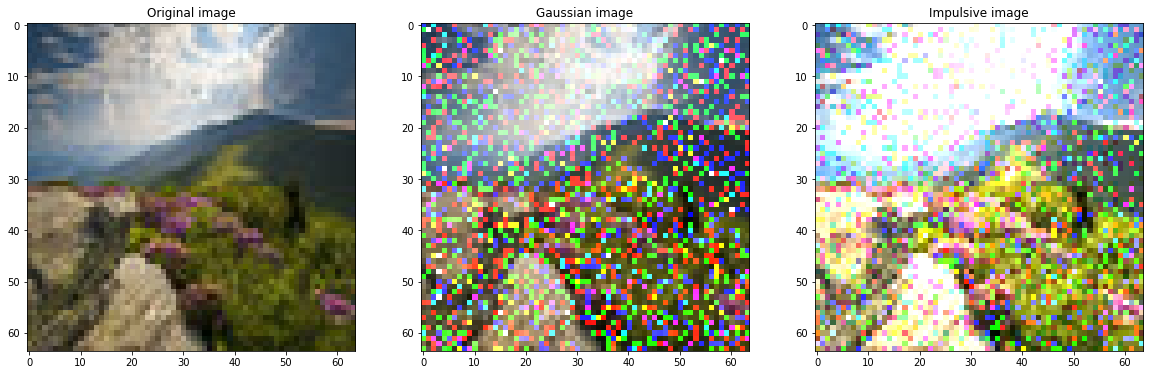

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:106: RuntimeWarning: overflow encountered in ubyte_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:131: RuntimeWarning: overflow encountered in ubyte_scalars


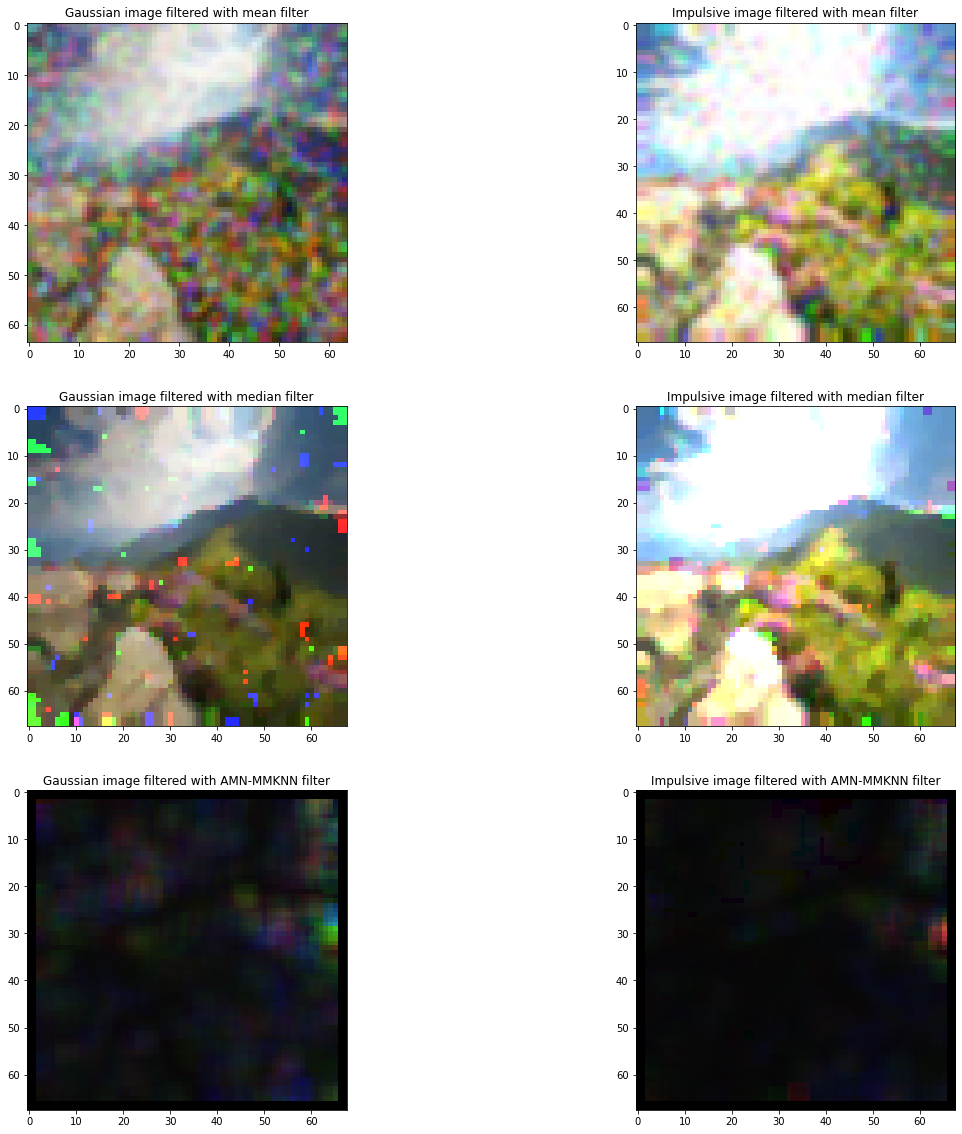

PSNR value for gaussian filtered image with mean is:  16.244554509559308
SSIM value for gaussian filtered image with mean is:  0.4861783197387934


PSNR value for impulsive filtered image with mean is:  10.243519508026534
SSIM value for impulsive filtered image with mean is:  0.481071941472214


PSNR value for gaussian filtered image with median is:  19.665528602012444
SSIM value for gaussian filtered image with median is:  0.6928033809808105


PSNR value for impulsive filtered image with median is:  10.030974083245995
SSIM value for impulsive filtered image with median is:  0.5079304514235511


PSNR value for gaussian filtered image with AMN-MMKNN is:  7.86352887426956
SSIM value for gaussian filtered image with AMN-MMKNN is:  0.06214737716979927


PSNR value for impulsive filtered image with AMN-MMKNN is:  7.86352887426956
SSIM value for impulsive filtered image with AMN-MMKNN is:  0.06214737716979927


In [ ]:
img6 = io.imread("img6.jpg")

noisy_image_gaussian = img6.copy()
noisy_image_impulsive = img6.copy()

#Create gaussian and impsulsive noise 
gaussian = np.random.normal(2,3, (img6.shape[0], img6.shape[1], img6.shape[2])).astype('uint8')
impulsive = random_noise(img6, mode='s&p',amount=0.2)
impulsive = np.array(255*impulsive, dtype = 'uint8')

# Add gaussian and impulsive noise to the image
noisy_image_gaussian = cv2.add(img6,gaussian)
noisy_image_impulsive = cv2.add(img6,impulsive)

# Create paded images for images affected by gaussian and impulsive noise
padded_noisy_image_gaussian = cv2.copyMakeBorder(noisy_image_gaussian, 2, 2, 2, 2, cv2.BORDER_REPLICATE)
padded_noisy_image_impulsive = cv2.copyMakeBorder(noisy_image_impulsive, 2, 2, 2, 2, cv2.BORDER_REPLICATE)

#Output filter image used in amn_mmknn_filter function
new_image = np.zeros(padded_noisy_image_gaussian.shape).astype(np.uint8)

#Plot original + gaussian + impulsive images
fig = plt.figure(figsize=(20, 20))

ax1 = fig.add_subplot(1,3,1)
ax1.imshow(img6)
ax1.title.set_text('Original image')

ax2 = fig.add_subplot(1,3,2)
ax2.imshow(noisy_image_gaussian)
ax2.title.set_text('Gaussian image')

ax3 = fig.add_subplot(1,3,3)
ax3.imshow(noisy_image_impulsive)
ax3.title.set_text('Impulsive image')

plt.show()


# Plot the filtered images

fig = plt.figure(figsize=(20, 20))

ax1 = fig.add_subplot(3,2,1)
ax1.imshow(cv2.GaussianBlur(noisy_image_gaussian,(3,3),0,cv2.BORDER_CONSTANT))
ax1.title.set_text('Gaussian image filtered with mean filter')

ax2 = fig.add_subplot(3,2,2)
ax2.imshow(cv2.GaussianBlur(padded_noisy_image_impulsive,(3,3),0,cv2.BORDER_CONSTANT))
ax2.title.set_text('Impulsive image filtered with mean filter')

ax3 = fig.add_subplot(3,2,3)
ax3.imshow(cv2.medianBlur(padded_noisy_image_gaussian, 3))
ax3.title.set_text('Gaussian image filtered with median filter')

ax4 = fig.add_subplot(3,2,4)
ax4.imshow(cv2.medianBlur(padded_noisy_image_impulsive, 3))
ax4.title.set_text('Impulsive image filtered with median filter')

ax5 = fig.add_subplot(3,2,5)
ax5.imshow(amn_mmknn_filter(padded_noisy_image_gaussian))
ax5.title.set_text('Gaussian image filtered with AMN-MMKNN filter')

ax6 = fig.add_subplot(3,2,6)
ax6.imshow(amn_mmknn_filter(padded_noisy_image_impulsive))
ax6.title.set_text('Impulsive image filtered with AMN-MMKNN filter')

plt.show()


#Padded original image used to calculate PSNR and SSIM for image with gaussian noise
original_image = cv2.copyMakeBorder(img6, 2, 2, 2, 2, cv2.BORDER_REPLICATE)

print('PSNR value for gaussian filtered image with mean is: ', calculate_psnr(original_image, cv2.GaussianBlur(padded_noisy_image_gaussian,(3,3),0,cv2.BORDER_CONSTANT)))
print('SSIM value for gaussian filtered image with mean is: ', calculate_ssim(original_image, cv2.GaussianBlur(padded_noisy_image_gaussian,(3,3),0,cv2.BORDER_CONSTANT)))
print('\n')

print('PSNR value for impulsive filtered image with mean is: ', calculate_psnr(original_image, cv2.GaussianBlur(padded_noisy_image_impulsive,(3,3),0,cv2.BORDER_CONSTANT)))
print('SSIM value for impulsive filtered image with mean is: ', calculate_ssim(original_image, cv2.GaussianBlur(padded_noisy_image_impulsive,(3,3),0,cv2.BORDER_CONSTANT)))
print('\n')

print('PSNR value for gaussian filtered image with median is: ', calculate_psnr(original_image, cv2.medianBlur(padded_noisy_image_gaussian, 3)))
print('SSIM value for gaussian filtered image with median is: ', calculate_ssim(original_image, cv2.medianBlur(padded_noisy_image_gaussian, 3)))
print('\n')

print('PSNR value for impulsive filtered image with median is: ', calculate_psnr(original_image, cv2.medianBlur(padded_noisy_image_impulsive, 3)))
print('SSIM value for impulsive filtered image with median is: ', calculate_ssim(original_image, cv2.medianBlur(padded_noisy_image_impulsive, 3)))
print('\n')


print('PSNR value for gaussian filtered image with AMN-MMKNN is: ', calculate_psnr(original_image, amn_mmknn_filter(padded_noisy_image_gaussian)))
print('SSIM value for gaussian filtered image with AMN-MMKNN is: ', calculate_ssim(original_image, amn_mmknn_filter(padded_noisy_image_gaussian)))
print('\n')

print('PSNR value for impulsive filtered image with AMN-MMKNN is: ', calculate_psnr(original_image, amn_mmknn_filter(padded_noisy_image_gaussian)))
print('SSIM value for impulsive filtered image with AMN-MMKNN is: ', calculate_ssim(original_image, amn_mmknn_filter(padded_noisy_image_gaussian)))

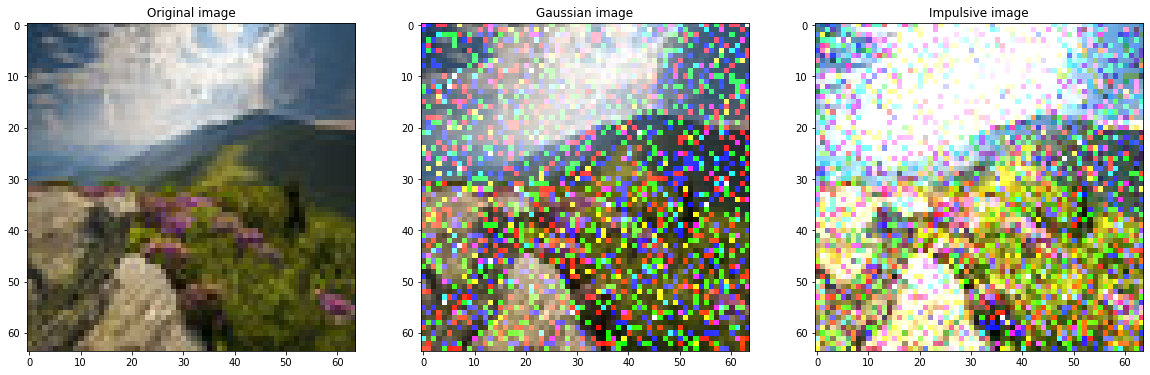

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:106: RuntimeWarning: overflow encountered in ubyte_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:131: RuntimeWarning: overflow encountered in ubyte_scalars


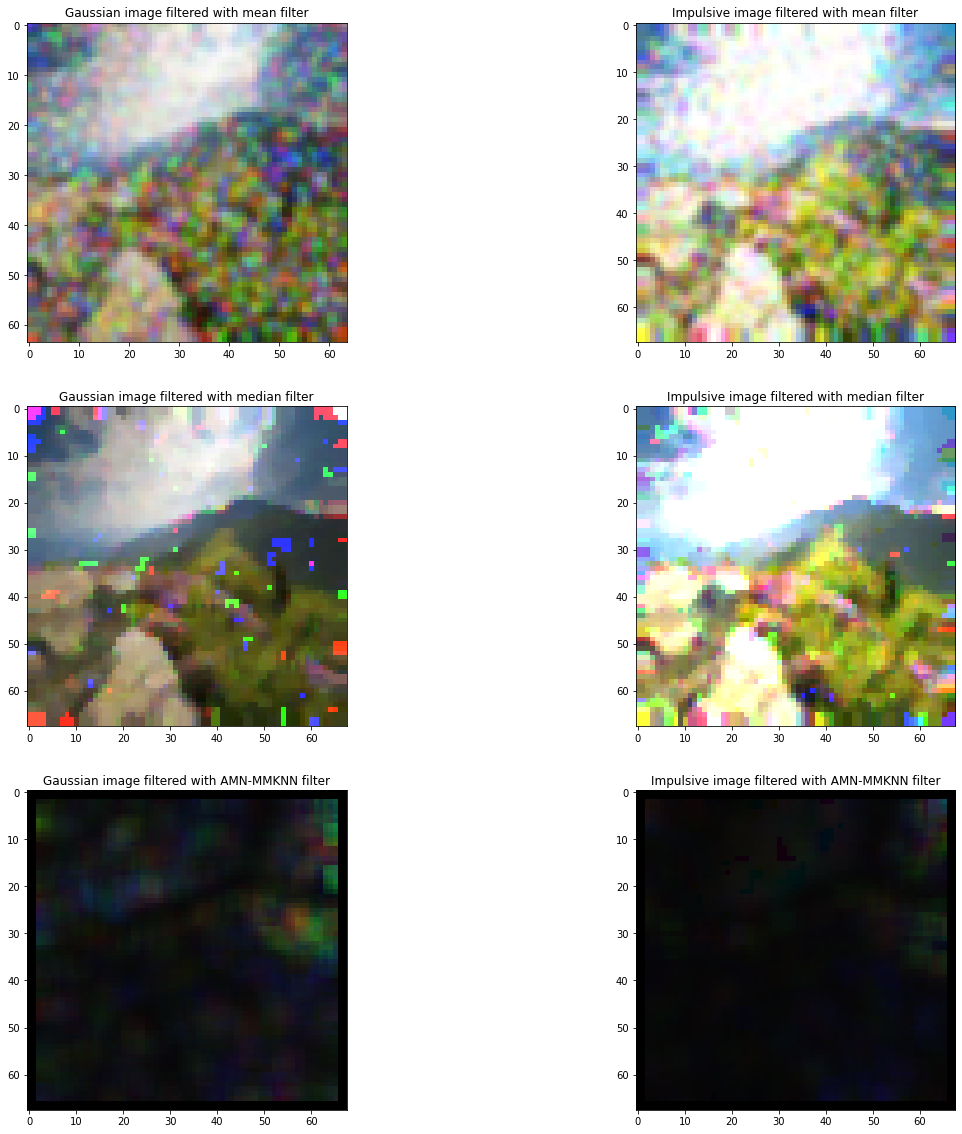

PSNR value for gaussian filtered image with mean is:  15.917100118339242
SSIM value for gaussian filtered image with mean is:  0.4805588687619873


PSNR value for impulsive filtered image with mean is:  10.055675800630146
SSIM value for impulsive filtered image with mean is:  0.44778021709415167


PSNR value for gaussian filtered image with median is:  19.02310136264393
SSIM value for gaussian filtered image with median is:  0.6783367657692668


PSNR value for impulsive filtered image with median is:  9.753500574248879
SSIM value for impulsive filtered image with median is:  0.4708008987858399


PSNR value for gaussian filtered image with AMN-MMKNN is:  7.841933068479978
SSIM value for gaussian filtered image with AMN-MMKNN is:  0.06188049372538715


PSNR value for impulsive filtered image with AMN-MMKNN is:  7.841933068479978
SSIM value for impulsive filtered image with AMN-MMKNN is:  0.06188049372538715


In [ ]:
img6 = io.imread("img6.jpg")

noisy_image_gaussian = img6.copy()
noisy_image_impulsive = img6.copy()

#Create gaussian and impsulsive noise 
gaussian = np.random.normal(3,4, (img6.shape[0], img6.shape[1], img6.shape[2])).astype('uint8')
impulsive = random_noise(img6, mode='s&p',amount=0.3)
impulsive = np.array(255*impulsive, dtype = 'uint8')

# Add gaussian and impulsive noise to the image
noisy_image_gaussian = cv2.add(img6,gaussian)
noisy_image_impulsive = cv2.add(img6,impulsive)

# Create paded images for images affected by gaussian and impulsive noise
padded_noisy_image_gaussian = cv2.copyMakeBorder(noisy_image_gaussian, 2, 2, 2, 2, cv2.BORDER_REPLICATE)
padded_noisy_image_impulsive = cv2.copyMakeBorder(noisy_image_impulsive, 2, 2, 2, 2, cv2.BORDER_REPLICATE)

#Output filter image used in amn_mmknn_filter function
new_image = np.zeros(padded_noisy_image_gaussian.shape).astype(np.uint8)

#Plot original + gaussian + impulsive images
fig = plt.figure(figsize=(20, 20))

ax1 = fig.add_subplot(1,3,1)
ax1.imshow(img6)
ax1.title.set_text('Original image')

ax2 = fig.add_subplot(1,3,2)
ax2.imshow(noisy_image_gaussian)
ax2.title.set_text('Gaussian image')

ax3 = fig.add_subplot(1,3,3)
ax3.imshow(noisy_image_impulsive)
ax3.title.set_text('Impulsive image')

plt.show()


# Plot the filtered images

fig = plt.figure(figsize=(20, 20))

ax1 = fig.add_subplot(3,2,1)
ax1.imshow(cv2.GaussianBlur(noisy_image_gaussian,(3,3),0,cv2.BORDER_CONSTANT))
ax1.title.set_text('Gaussian image filtered with mean filter')

ax2 = fig.add_subplot(3,2,2)
ax2.imshow(cv2.GaussianBlur(padded_noisy_image_impulsive,(3,3),0,cv2.BORDER_CONSTANT))
ax2.title.set_text('Impulsive image filtered with mean filter')

ax3 = fig.add_subplot(3,2,3)
ax3.imshow(cv2.medianBlur(padded_noisy_image_gaussian, 3))
ax3.title.set_text('Gaussian image filtered with median filter')

ax4 = fig.add_subplot(3,2,4)
ax4.imshow(cv2.medianBlur(padded_noisy_image_impulsive, 3))
ax4.title.set_text('Impulsive image filtered with median filter')

ax5 = fig.add_subplot(3,2,5)
ax5.imshow(amn_mmknn_filter(padded_noisy_image_gaussian))
ax5.title.set_text('Gaussian image filtered with AMN-MMKNN filter')

ax6 = fig.add_subplot(3,2,6)
ax6.imshow(amn_mmknn_filter(padded_noisy_image_impulsive))
ax6.title.set_text('Impulsive image filtered with AMN-MMKNN filter')

plt.show()


#Padded original image used to calculate PSNR and SSIM for image with gaussian noise
original_image = cv2.copyMakeBorder(img6, 2, 2, 2, 2, cv2.BORDER_REPLICATE)

print('PSNR value for gaussian filtered image with mean is: ', calculate_psnr(original_image, cv2.GaussianBlur(padded_noisy_image_gaussian,(3,3),0,cv2.BORDER_CONSTANT)))
print('SSIM value for gaussian filtered image with mean is: ', calculate_ssim(original_image, cv2.GaussianBlur(padded_noisy_image_gaussian,(3,3),0,cv2.BORDER_CONSTANT)))
print('\n')

print('PSNR value for impulsive filtered image with mean is: ', calculate_psnr(original_image, cv2.GaussianBlur(padded_noisy_image_impulsive,(3,3),0,cv2.BORDER_CONSTANT)))
print('SSIM value for impulsive filtered image with mean is: ', calculate_ssim(original_image, cv2.GaussianBlur(padded_noisy_image_impulsive,(3,3),0,cv2.BORDER_CONSTANT)))
print('\n')

print('PSNR value for gaussian filtered image with median is: ', calculate_psnr(original_image, cv2.medianBlur(padded_noisy_image_gaussian, 3)))
print('SSIM value for gaussian filtered image with median is: ', calculate_ssim(original_image, cv2.medianBlur(padded_noisy_image_gaussian, 3)))
print('\n')

print('PSNR value for impulsive filtered image with median is: ', calculate_psnr(original_image, cv2.medianBlur(padded_noisy_image_impulsive, 3)))
print('SSIM value for impulsive filtered image with median is: ', calculate_ssim(original_image, cv2.medianBlur(padded_noisy_image_impulsive, 3)))
print('\n')


print('PSNR value for gaussian filtered image with AMN-MMKNN is: ', calculate_psnr(original_image, amn_mmknn_filter(padded_noisy_image_gaussian)))
print('SSIM value for gaussian filtered image with AMN-MMKNN is: ', calculate_ssim(original_image, amn_mmknn_filter(padded_noisy_image_gaussian)))
print('\n')

print('PSNR value for impulsive filtered image with AMN-MMKNN is: ', calculate_psnr(original_image, amn_mmknn_filter(padded_noisy_image_gaussian)))
print('SSIM value for impulsive filtered image with AMN-MMKNN is: ', calculate_ssim(original_image, amn_mmknn_filter(padded_noisy_image_gaussian)))

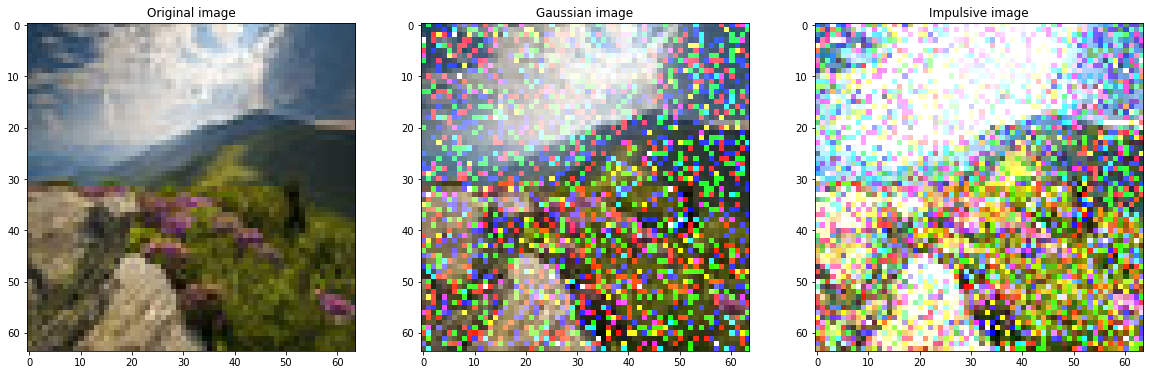

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:106: RuntimeWarning: overflow encountered in ubyte_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:131: RuntimeWarning: overflow encountered in ubyte_scalars


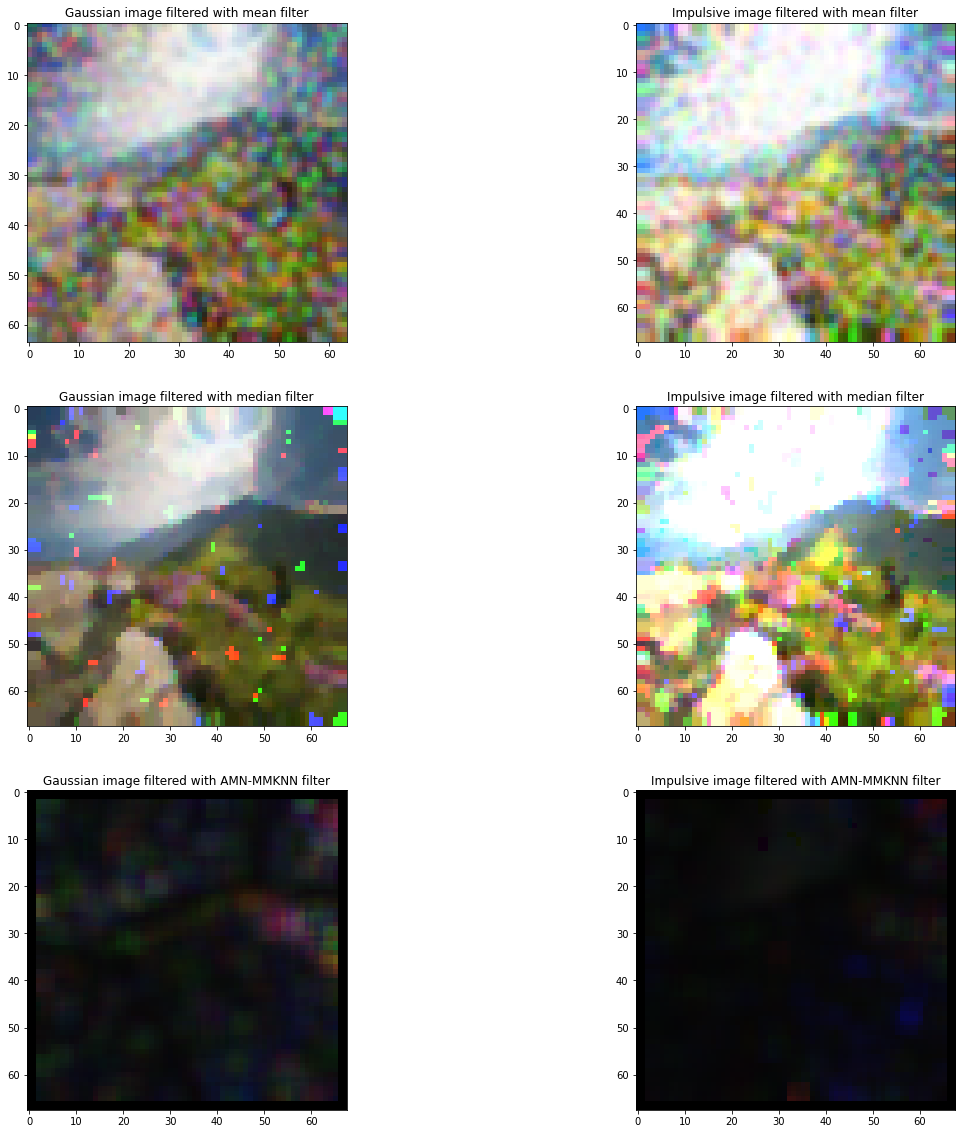

PSNR value for gaussian filtered image with mean is:  15.973687562338647
SSIM value for gaussian filtered image with mean is:  0.4814293015811633


PSNR value for impulsive filtered image with mean is:  10.065425894619862
SSIM value for impulsive filtered image with mean is:  0.4184163661604543


PSNR value for gaussian filtered image with median is:  19.991068382486393
SSIM value for gaussian filtered image with median is:  0.6857646131345106


PSNR value for impulsive filtered image with median is:  9.633110045970446
SSIM value for impulsive filtered image with median is:  0.409724995009002


PSNR value for gaussian filtered image with AMN-MMKNN is:  7.863365846135557
SSIM value for gaussian filtered image with AMN-MMKNN is:  0.06264762676437975


PSNR value for impulsive filtered image with AMN-MMKNN is:  7.863365846135557
SSIM value for impulsive filtered image with AMN-MMKNN is:  0.06264762676437975


In [ ]:
img6 = io.imread("img6.jpg")

noisy_image_gaussian = img6.copy()
noisy_image_impulsive = img6.copy()

#Create gaussian and impsulsive noise 
gaussian = np.random.normal(4,5, (img6.shape[0], img6.shape[1], img6.shape[2])).astype('uint8')
impulsive = random_noise(img6, mode='s&p',amount=0.4)
impulsive = np.array(255*impulsive, dtype = 'uint8')

# Add gaussian and impulsive noise to the image
noisy_image_gaussian = cv2.add(img6,gaussian)
noisy_image_impulsive = cv2.add(img6,impulsive)

# Create paded images for images affected by gaussian and impulsive noise
padded_noisy_image_gaussian = cv2.copyMakeBorder(noisy_image_gaussian, 2, 2, 2, 2, cv2.BORDER_REPLICATE)
padded_noisy_image_impulsive = cv2.copyMakeBorder(noisy_image_impulsive, 2, 2, 2, 2, cv2.BORDER_REPLICATE)

#Output filter image used in amn_mmknn_filter function
new_image = np.zeros(padded_noisy_image_gaussian.shape).astype(np.uint8)

#Plot original + gaussian + impulsive images
fig = plt.figure(figsize=(20, 20))

ax1 = fig.add_subplot(1,3,1)
ax1.imshow(img6)
ax1.title.set_text('Original image')

ax2 = fig.add_subplot(1,3,2)
ax2.imshow(noisy_image_gaussian)
ax2.title.set_text('Gaussian image')

ax3 = fig.add_subplot(1,3,3)
ax3.imshow(noisy_image_impulsive)
ax3.title.set_text('Impulsive image')

plt.show()


# Plot the filtered images

fig = plt.figure(figsize=(20, 20))

ax1 = fig.add_subplot(3,2,1)
ax1.imshow(cv2.GaussianBlur(noisy_image_gaussian,(3,3),0,cv2.BORDER_CONSTANT))
ax1.title.set_text('Gaussian image filtered with mean filter')

ax2 = fig.add_subplot(3,2,2)
ax2.imshow(cv2.GaussianBlur(padded_noisy_image_impulsive,(3,3),0,cv2.BORDER_CONSTANT))
ax2.title.set_text('Impulsive image filtered with mean filter')

ax3 = fig.add_subplot(3,2,3)
ax3.imshow(cv2.medianBlur(padded_noisy_image_gaussian, 3))
ax3.title.set_text('Gaussian image filtered with median filter')

ax4 = fig.add_subplot(3,2,4)
ax4.imshow(cv2.medianBlur(padded_noisy_image_impulsive, 3))
ax4.title.set_text('Impulsive image filtered with median filter')

ax5 = fig.add_subplot(3,2,5)
ax5.imshow(amn_mmknn_filter(padded_noisy_image_gaussian))
ax5.title.set_text('Gaussian image filtered with AMN-MMKNN filter')

ax6 = fig.add_subplot(3,2,6)
ax6.imshow(amn_mmknn_filter(padded_noisy_image_impulsive))
ax6.title.set_text('Impulsive image filtered with AMN-MMKNN filter')

plt.show()


#Padded original image used to calculate PSNR and SSIM for image with gaussian noise
original_image = cv2.copyMakeBorder(img6, 2, 2, 2, 2, cv2.BORDER_REPLICATE)

print('PSNR value for gaussian filtered image with mean is: ', calculate_psnr(original_image, cv2.GaussianBlur(padded_noisy_image_gaussian,(3,3),0,cv2.BORDER_CONSTANT)))
print('SSIM value for gaussian filtered image with mean is: ', calculate_ssim(original_image, cv2.GaussianBlur(padded_noisy_image_gaussian,(3,3),0,cv2.BORDER_CONSTANT)))
print('\n')

print('PSNR value for impulsive filtered image with mean is: ', calculate_psnr(original_image, cv2.GaussianBlur(padded_noisy_image_impulsive,(3,3),0,cv2.BORDER_CONSTANT)))
print('SSIM value for impulsive filtered image with mean is: ', calculate_ssim(original_image, cv2.GaussianBlur(padded_noisy_image_impulsive,(3,3),0,cv2.BORDER_CONSTANT)))
print('\n')

print('PSNR value for gaussian filtered image with median is: ', calculate_psnr(original_image, cv2.medianBlur(padded_noisy_image_gaussian, 3)))
print('SSIM value for gaussian filtered image with median is: ', calculate_ssim(original_image, cv2.medianBlur(padded_noisy_image_gaussian, 3)))
print('\n')

print('PSNR value for impulsive filtered image with median is: ', calculate_psnr(original_image, cv2.medianBlur(padded_noisy_image_impulsive, 3)))
print('SSIM value for impulsive filtered image with median is: ', calculate_ssim(original_image, cv2.medianBlur(padded_noisy_image_impulsive, 3)))
print('\n')


print('PSNR value for gaussian filtered image with AMN-MMKNN is: ', calculate_psnr(original_image, amn_mmknn_filter(padded_noisy_image_gaussian)))
print('SSIM value for gaussian filtered image with AMN-MMKNN is: ', calculate_ssim(original_image, amn_mmknn_filter(padded_noisy_image_gaussian)))
print('\n')

print('PSNR value for impulsive filtered image with AMN-MMKNN is: ', calculate_psnr(original_image, amn_mmknn_filter(padded_noisy_image_gaussian)))
print('SSIM value for impulsive filtered image with AMN-MMKNN is: ', calculate_ssim(original_image, amn_mmknn_filter(padded_noisy_image_gaussian)))

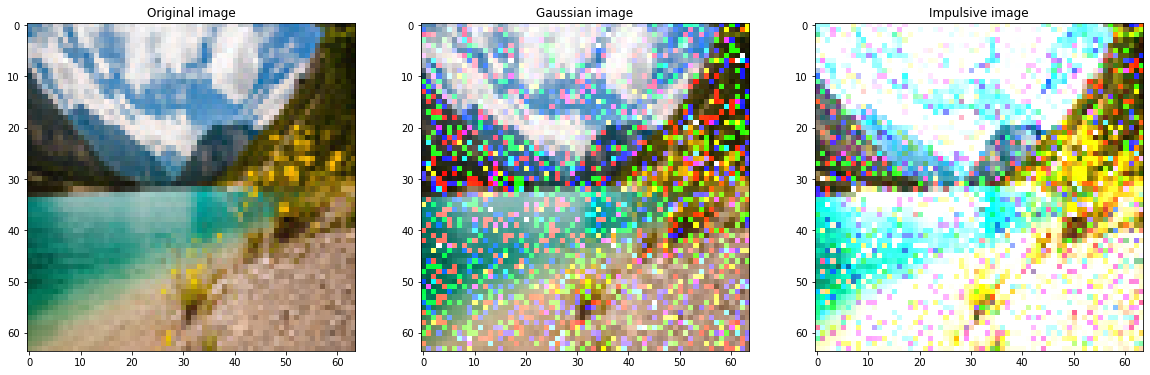

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:106: RuntimeWarning: overflow encountered in ubyte_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:131: RuntimeWarning: overflow encountered in ubyte_scalars


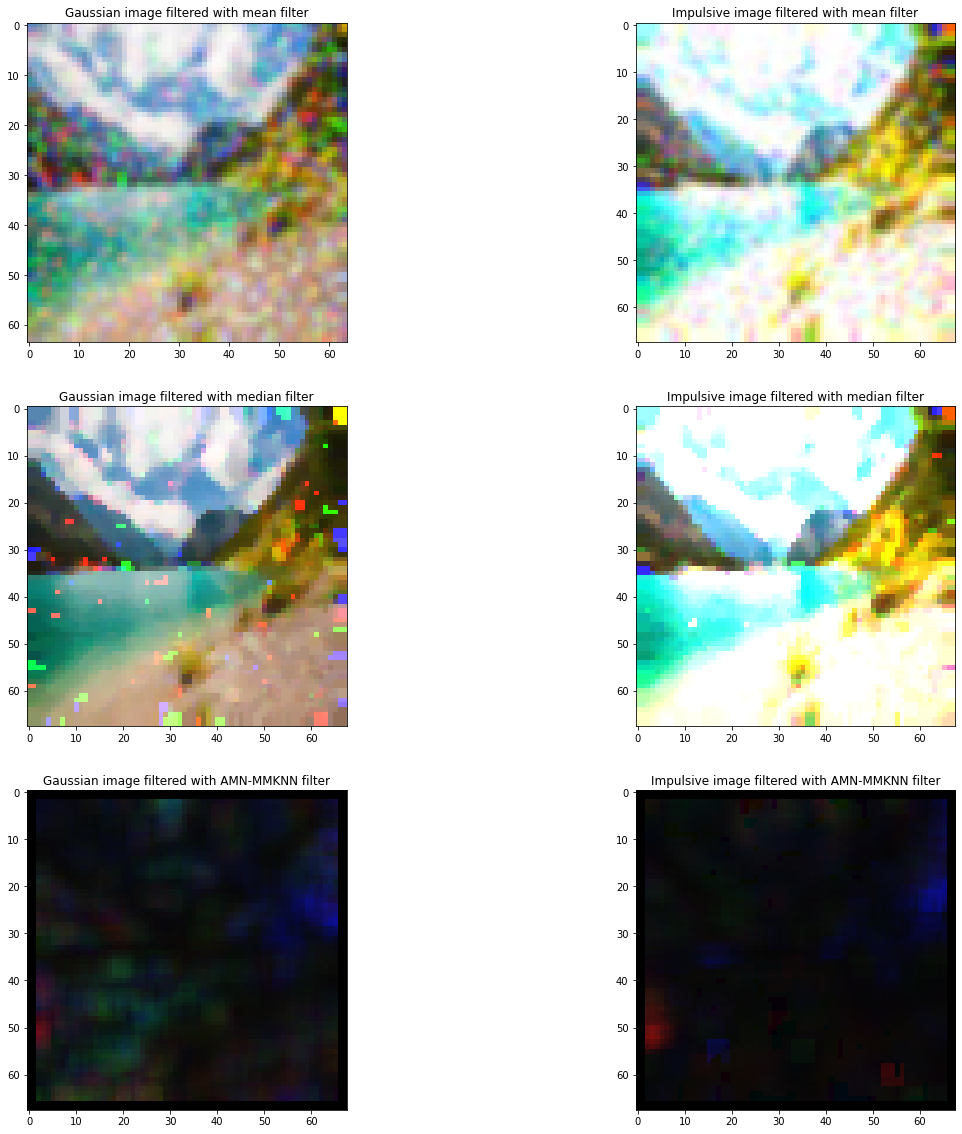

PSNR value for gaussian filtered image with mean is:  17.007506171768743
SSIM value for gaussian filtered image with mean is:  0.5892757514264283


PSNR value for impulsive filtered image with mean is:  10.114048819464326
SSIM value for impulsive filtered image with mean is:  0.4621606230017632


PSNR value for gaussian filtered image with median is:  19.29266958567489
SSIM value for gaussian filtered image with median is:  0.6985975837591317


PSNR value for impulsive filtered image with median is:  9.4955378965258
SSIM value for impulsive filtered image with median is:  0.44321567058190886


PSNR value for gaussian filtered image with AMN-MMKNN is:  5.907267725913493
SSIM value for gaussian filtered image with AMN-MMKNN is:  0.03608003536360885


PSNR value for impulsive filtered image with AMN-MMKNN is:  5.907267725913493
SSIM value for impulsive filtered image with AMN-MMKNN is:  0.03608003536360885


In [ ]:
img7 = io.imread("img7.jpg")

noisy_image_gaussian = img7.copy()
noisy_image_impulsive = img7.copy()

#Create gaussian and impsulsive noise 
gaussian = np.random.normal(2,3, (img7.shape[0], img7.shape[1], img7.shape[2])).astype('uint8')
impulsive = random_noise(img7, mode='s&p',amount=0.2)
impulsive = np.array(255*impulsive, dtype = 'uint8')

# Add gaussian and impulsive noise to the image
noisy_image_gaussian = cv2.add(img7,gaussian)
noisy_image_impulsive = cv2.add(img7,impulsive)

# Create paded images for images affected by gaussian and impulsive noise
padded_noisy_image_gaussian = cv2.copyMakeBorder(noisy_image_gaussian, 2, 2, 2, 2, cv2.BORDER_REPLICATE)
padded_noisy_image_impulsive = cv2.copyMakeBorder(noisy_image_impulsive, 2, 2, 2, 2, cv2.BORDER_REPLICATE)

#Output filter image used in amn_mmknn_filter function
new_image = np.zeros(padded_noisy_image_gaussian.shape).astype(np.uint8)

#Plot original + gaussian + impulsive images
fig = plt.figure(figsize=(20, 20))

ax1 = fig.add_subplot(1,3,1)
ax1.imshow(img7)
ax1.title.set_text('Original image')

ax2 = fig.add_subplot(1,3,2)
ax2.imshow(noisy_image_gaussian)
ax2.title.set_text('Gaussian image')

ax3 = fig.add_subplot(1,3,3)
ax3.imshow(noisy_image_impulsive)
ax3.title.set_text('Impulsive image')

plt.show()


# Plot the filtered images

fig = plt.figure(figsize=(20, 20))

ax1 = fig.add_subplot(3,2,1)
ax1.imshow(cv2.GaussianBlur(noisy_image_gaussian,(3,3),0,cv2.BORDER_CONSTANT))
ax1.title.set_text('Gaussian image filtered with mean filter')

ax2 = fig.add_subplot(3,2,2)
ax2.imshow(cv2.GaussianBlur(padded_noisy_image_impulsive,(3,3),0,cv2.BORDER_CONSTANT))
ax2.title.set_text('Impulsive image filtered with mean filter')

ax3 = fig.add_subplot(3,2,3)
ax3.imshow(cv2.medianBlur(padded_noisy_image_gaussian, 3))
ax3.title.set_text('Gaussian image filtered with median filter')

ax4 = fig.add_subplot(3,2,4)
ax4.imshow(cv2.medianBlur(padded_noisy_image_impulsive, 3))
ax4.title.set_text('Impulsive image filtered with median filter')

ax5 = fig.add_subplot(3,2,5)
ax5.imshow(amn_mmknn_filter(padded_noisy_image_gaussian))
ax5.title.set_text('Gaussian image filtered with AMN-MMKNN filter')

ax6 = fig.add_subplot(3,2,6)
ax6.imshow(amn_mmknn_filter(padded_noisy_image_impulsive))
ax6.title.set_text('Impulsive image filtered with AMN-MMKNN filter')

plt.show()


#Padded original image used to calculate PSNR and SSIM for image with gaussian noise
original_image = cv2.copyMakeBorder(img7, 2, 2, 2, 2, cv2.BORDER_REPLICATE)

print('PSNR value for gaussian filtered image with mean is: ', calculate_psnr(original_image, cv2.GaussianBlur(padded_noisy_image_gaussian,(3,3),0,cv2.BORDER_CONSTANT)))
print('SSIM value for gaussian filtered image with mean is: ', calculate_ssim(original_image, cv2.GaussianBlur(padded_noisy_image_gaussian,(3,3),0,cv2.BORDER_CONSTANT)))
print('\n')

print('PSNR value for impulsive filtered image with mean is: ', calculate_psnr(original_image, cv2.GaussianBlur(padded_noisy_image_impulsive,(3,3),0,cv2.BORDER_CONSTANT)))
print('SSIM value for impulsive filtered image with mean is: ', calculate_ssim(original_image, cv2.GaussianBlur(padded_noisy_image_impulsive,(3,3),0,cv2.BORDER_CONSTANT)))
print('\n')

print('PSNR value for gaussian filtered image with median is: ', calculate_psnr(original_image, cv2.medianBlur(padded_noisy_image_gaussian, 3)))
print('SSIM value for gaussian filtered image with median is: ', calculate_ssim(original_image, cv2.medianBlur(padded_noisy_image_gaussian, 3)))
print('\n')

print('PSNR value for impulsive filtered image with median is: ', calculate_psnr(original_image, cv2.medianBlur(padded_noisy_image_impulsive, 3)))
print('SSIM value for impulsive filtered image with median is: ', calculate_ssim(original_image, cv2.medianBlur(padded_noisy_image_impulsive, 3)))
print('\n')


print('PSNR value for gaussian filtered image with AMN-MMKNN is: ', calculate_psnr(original_image, amn_mmknn_filter(padded_noisy_image_gaussian)))
print('SSIM value for gaussian filtered image with AMN-MMKNN is: ', calculate_ssim(original_image, amn_mmknn_filter(padded_noisy_image_gaussian)))
print('\n')

print('PSNR value for impulsive filtered image with AMN-MMKNN is: ', calculate_psnr(original_image, amn_mmknn_filter(padded_noisy_image_gaussian)))
print('SSIM value for impulsive filtered image with AMN-MMKNN is: ', calculate_ssim(original_image, amn_mmknn_filter(padded_noisy_image_gaussian)))

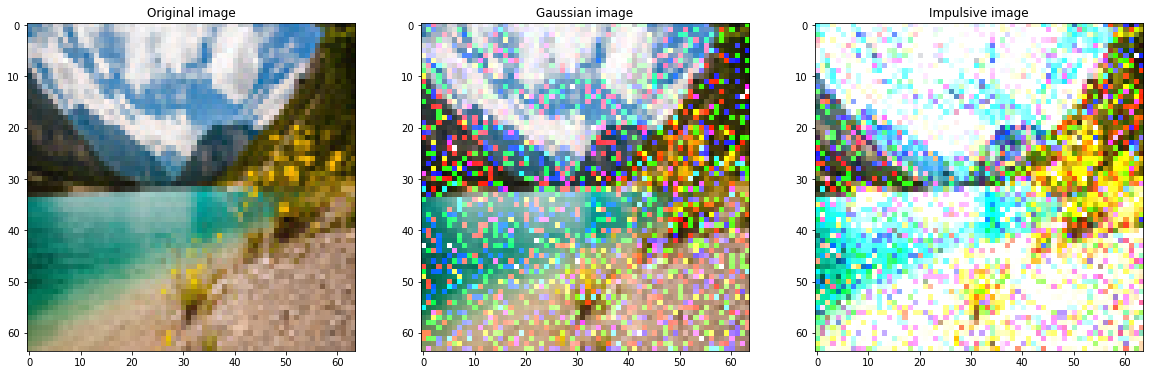

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:106: RuntimeWarning: overflow encountered in ubyte_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:131: RuntimeWarning: overflow encountered in ubyte_scalars


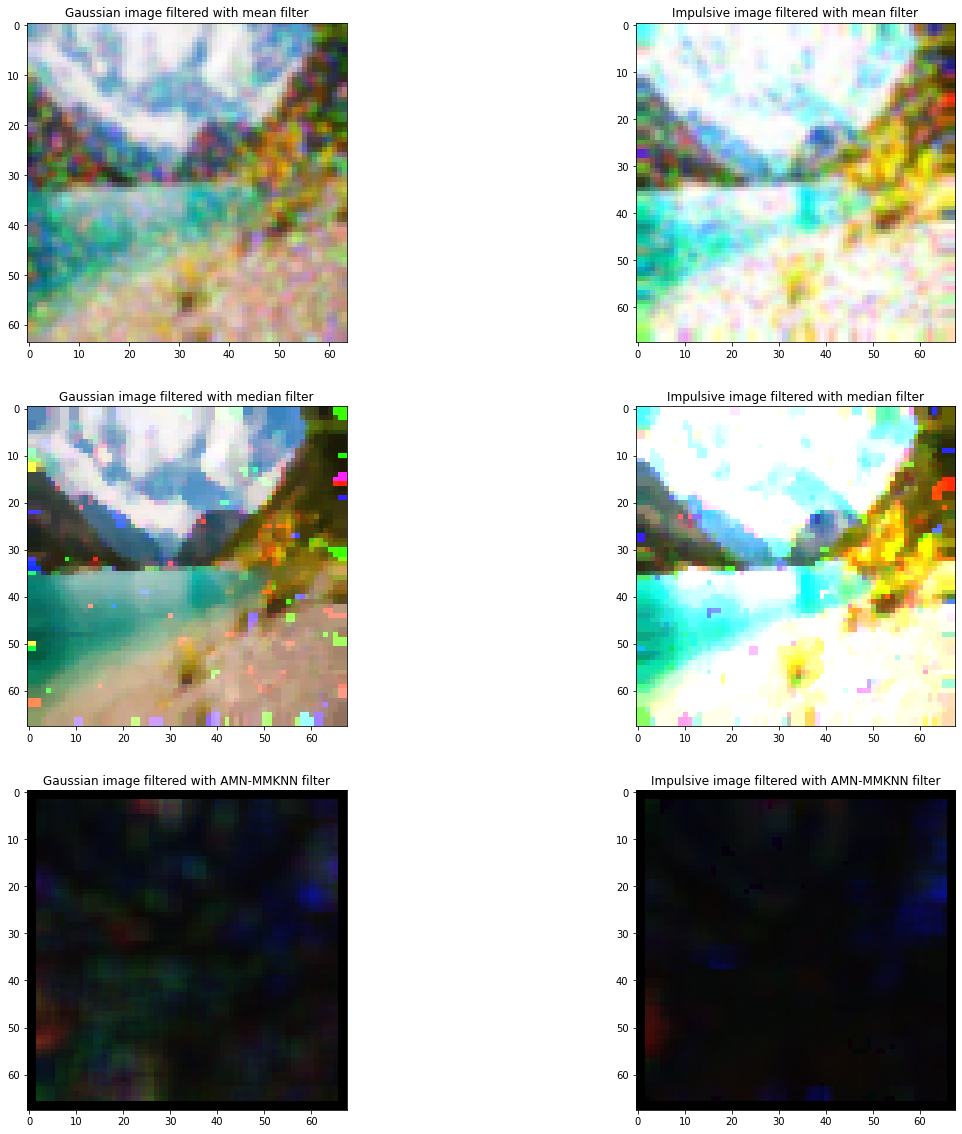

PSNR value for gaussian filtered image with mean is:  17.064137654260705
SSIM value for gaussian filtered image with mean is:  0.5981037824012176


PSNR value for impulsive filtered image with mean is:  10.346153423622154
SSIM value for impulsive filtered image with mean is:  0.4382352943392234


PSNR value for gaussian filtered image with median is:  19.120525805007457
SSIM value for gaussian filtered image with median is:  0.7077397029853745


PSNR value for impulsive filtered image with median is:  9.46894882461317
SSIM value for impulsive filtered image with median is:  0.40821737885166315


PSNR value for gaussian filtered image with AMN-MMKNN is:  5.905848290273351
SSIM value for gaussian filtered image with AMN-MMKNN is:  0.039343511110111175


PSNR value for impulsive filtered image with AMN-MMKNN is:  5.905848290273351
SSIM value for impulsive filtered image with AMN-MMKNN is:  0.039343511110111175


In [ ]:
img7 = io.imread("img7.jpg")

noisy_image_gaussian = img7.copy()
noisy_image_impulsive = img7.copy()

#Create gaussian and impsulsive noise 
gaussian = np.random.normal(3,4, (img7.shape[0], img7.shape[1], img7.shape[2])).astype('uint8')
impulsive = random_noise(img7, mode='s&p',amount=0.3)
impulsive = np.array(255*impulsive, dtype = 'uint8')

# Add gaussian and impulsive noise to the image
noisy_image_gaussian = cv2.add(img7,gaussian)
noisy_image_impulsive = cv2.add(img7,impulsive)

# Create paded images for images affected by gaussian and impulsive noise
padded_noisy_image_gaussian = cv2.copyMakeBorder(noisy_image_gaussian, 2, 2, 2, 2, cv2.BORDER_REPLICATE)
padded_noisy_image_impulsive = cv2.copyMakeBorder(noisy_image_impulsive, 2, 2, 2, 2, cv2.BORDER_REPLICATE)

#Output filter image used in amn_mmknn_filter function
new_image = np.zeros(padded_noisy_image_gaussian.shape).astype(np.uint8)

#Plot original + gaussian + impulsive images
fig = plt.figure(figsize=(20, 20))

ax1 = fig.add_subplot(1,3,1)
ax1.imshow(img7)
ax1.title.set_text('Original image')

ax2 = fig.add_subplot(1,3,2)
ax2.imshow(noisy_image_gaussian)
ax2.title.set_text('Gaussian image')

ax3 = fig.add_subplot(1,3,3)
ax3.imshow(noisy_image_impulsive)
ax3.title.set_text('Impulsive image')

plt.show()


# Plot the filtered images

fig = plt.figure(figsize=(20, 20))

ax1 = fig.add_subplot(3,2,1)
ax1.imshow(cv2.GaussianBlur(noisy_image_gaussian,(3,3),0,cv2.BORDER_CONSTANT))
ax1.title.set_text('Gaussian image filtered with mean filter')

ax2 = fig.add_subplot(3,2,2)
ax2.imshow(cv2.GaussianBlur(padded_noisy_image_impulsive,(3,3),0,cv2.BORDER_CONSTANT))
ax2.title.set_text('Impulsive image filtered with mean filter')

ax3 = fig.add_subplot(3,2,3)
ax3.imshow(cv2.medianBlur(padded_noisy_image_gaussian, 3))
ax3.title.set_text('Gaussian image filtered with median filter')

ax4 = fig.add_subplot(3,2,4)
ax4.imshow(cv2.medianBlur(padded_noisy_image_impulsive, 3))
ax4.title.set_text('Impulsive image filtered with median filter')

ax5 = fig.add_subplot(3,2,5)
ax5.imshow(amn_mmknn_filter(padded_noisy_image_gaussian))
ax5.title.set_text('Gaussian image filtered with AMN-MMKNN filter')

ax6 = fig.add_subplot(3,2,6)
ax6.imshow(amn_mmknn_filter(padded_noisy_image_impulsive))
ax6.title.set_text('Impulsive image filtered with AMN-MMKNN filter')

plt.show()


#Padded original image used to calculate PSNR and SSIM for image with gaussian noise
original_image = cv2.copyMakeBorder(img7, 2, 2, 2, 2, cv2.BORDER_REPLICATE)

print('PSNR value for gaussian filtered image with mean is: ', calculate_psnr(original_image, cv2.GaussianBlur(padded_noisy_image_gaussian,(3,3),0,cv2.BORDER_CONSTANT)))
print('SSIM value for gaussian filtered image with mean is: ', calculate_ssim(original_image, cv2.GaussianBlur(padded_noisy_image_gaussian,(3,3),0,cv2.BORDER_CONSTANT)))
print('\n')

print('PSNR value for impulsive filtered image with mean is: ', calculate_psnr(original_image, cv2.GaussianBlur(padded_noisy_image_impulsive,(3,3),0,cv2.BORDER_CONSTANT)))
print('SSIM value for impulsive filtered image with mean is: ', calculate_ssim(original_image, cv2.GaussianBlur(padded_noisy_image_impulsive,(3,3),0,cv2.BORDER_CONSTANT)))
print('\n')

print('PSNR value for gaussian filtered image with median is: ', calculate_psnr(original_image, cv2.medianBlur(padded_noisy_image_gaussian, 3)))
print('SSIM value for gaussian filtered image with median is: ', calculate_ssim(original_image, cv2.medianBlur(padded_noisy_image_gaussian, 3)))
print('\n')

print('PSNR value for impulsive filtered image with median is: ', calculate_psnr(original_image, cv2.medianBlur(padded_noisy_image_impulsive, 3)))
print('SSIM value for impulsive filtered image with median is: ', calculate_ssim(original_image, cv2.medianBlur(padded_noisy_image_impulsive, 3)))
print('\n')


print('PSNR value for gaussian filtered image with AMN-MMKNN is: ', calculate_psnr(original_image, amn_mmknn_filter(padded_noisy_image_gaussian)))
print('SSIM value for gaussian filtered image with AMN-MMKNN is: ', calculate_ssim(original_image, amn_mmknn_filter(padded_noisy_image_gaussian)))
print('\n')

print('PSNR value for impulsive filtered image with AMN-MMKNN is: ', calculate_psnr(original_image, amn_mmknn_filter(padded_noisy_image_gaussian)))
print('SSIM value for impulsive filtered image with AMN-MMKNN is: ', calculate_ssim(original_image, amn_mmknn_filter(padded_noisy_image_gaussian)))

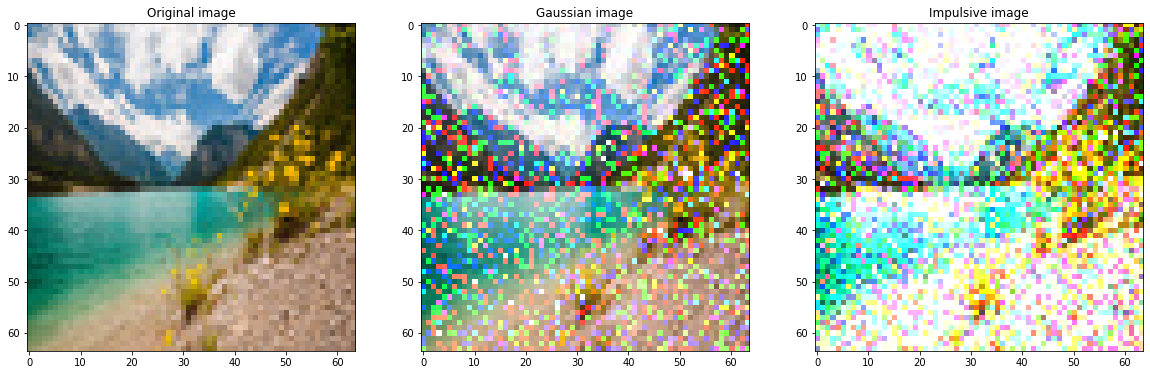

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:106: RuntimeWarning: overflow encountered in ubyte_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:131: RuntimeWarning: overflow encountered in ubyte_scalars


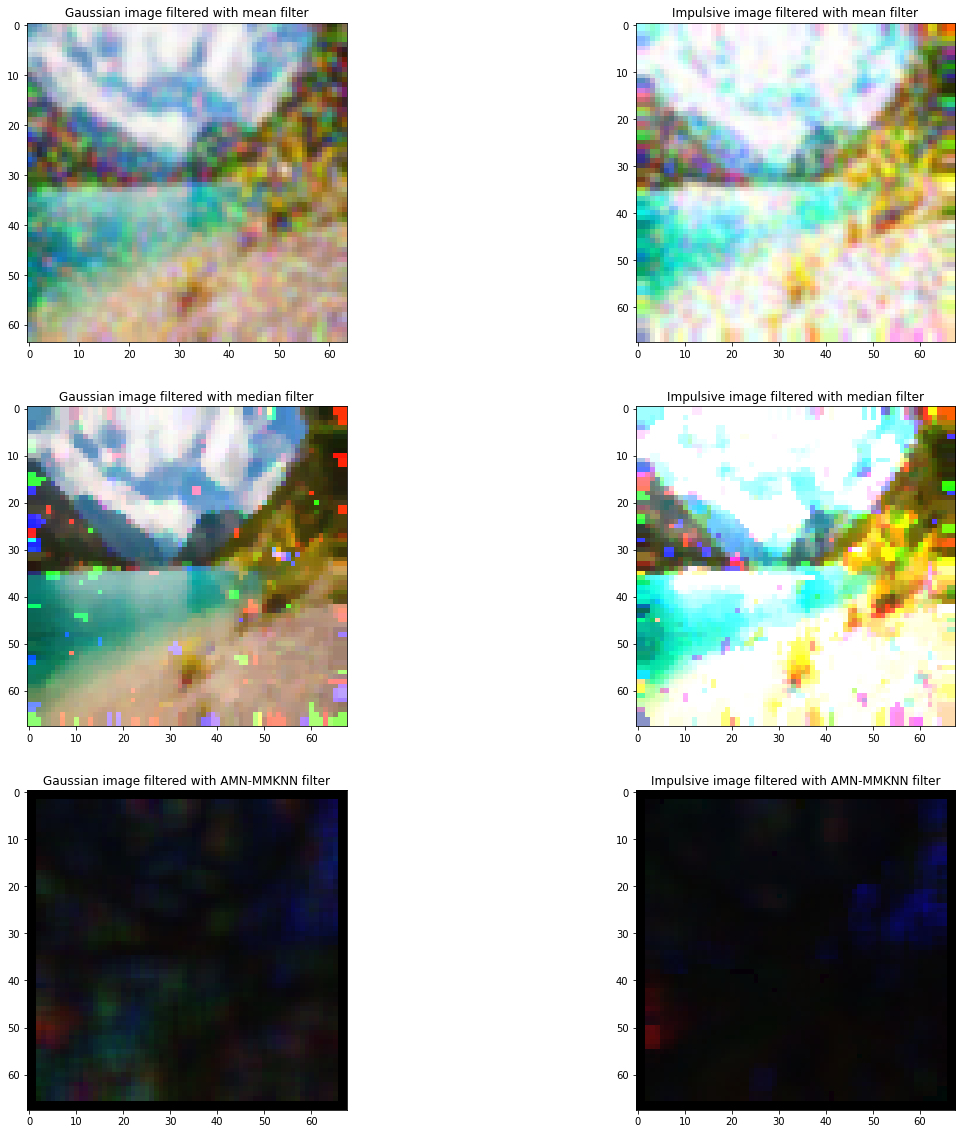

PSNR value for gaussian filtered image with mean is:  16.579701447551717
SSIM value for gaussian filtered image with mean is:  0.5853841755669675


PSNR value for impulsive filtered image with mean is:  10.436602875606582
SSIM value for impulsive filtered image with mean is:  0.42852838289599715


PSNR value for gaussian filtered image with median is:  18.627870417787427
SSIM value for gaussian filtered image with median is:  0.689136615284811


PSNR value for impulsive filtered image with median is:  9.43361177122721
SSIM value for impulsive filtered image with median is:  0.38460533957549775


PSNR value for gaussian filtered image with AMN-MMKNN is:  5.877409599815517
SSIM value for gaussian filtered image with AMN-MMKNN is:  0.04039036454759506


PSNR value for impulsive filtered image with AMN-MMKNN is:  5.877409599815517
SSIM value for impulsive filtered image with AMN-MMKNN is:  0.04039036454759506


In [ ]:
img7 = io.imread("img7.jpg")

noisy_image_gaussian = img7.copy()
noisy_image_impulsive = img7.copy()

#Create gaussian and impsulsive noise 
gaussian = np.random.normal(4,5, (img7.shape[0], img7.shape[1], img7.shape[2])).astype('uint8')
impulsive = random_noise(img7, mode='s&p',amount=0.4)
impulsive = np.array(255*impulsive, dtype = 'uint8')

# Add gaussian and impulsive noise to the image
noisy_image_gaussian = cv2.add(img7,gaussian)
noisy_image_impulsive = cv2.add(img7,impulsive)

# Create paded images for images affected by gaussian and impulsive noise
padded_noisy_image_gaussian = cv2.copyMakeBorder(noisy_image_gaussian, 2, 2, 2, 2, cv2.BORDER_REPLICATE)
padded_noisy_image_impulsive = cv2.copyMakeBorder(noisy_image_impulsive, 2, 2, 2, 2, cv2.BORDER_REPLICATE)

#Output filter image used in amn_mmknn_filter function
new_image = np.zeros(padded_noisy_image_gaussian.shape).astype(np.uint8)

#Plot original + gaussian + impulsive images
fig = plt.figure(figsize=(20, 20))

ax1 = fig.add_subplot(1,3,1)
ax1.imshow(img7)
ax1.title.set_text('Original image')

ax2 = fig.add_subplot(1,3,2)
ax2.imshow(noisy_image_gaussian)
ax2.title.set_text('Gaussian image')

ax3 = fig.add_subplot(1,3,3)
ax3.imshow(noisy_image_impulsive)
ax3.title.set_text('Impulsive image')

plt.show()


# Plot the filtered images

fig = plt.figure(figsize=(20, 20))

ax1 = fig.add_subplot(3,2,1)
ax1.imshow(cv2.GaussianBlur(noisy_image_gaussian,(3,3),0,cv2.BORDER_CONSTANT))
ax1.title.set_text('Gaussian image filtered with mean filter')

ax2 = fig.add_subplot(3,2,2)
ax2.imshow(cv2.GaussianBlur(padded_noisy_image_impulsive,(3,3),0,cv2.BORDER_CONSTANT))
ax2.title.set_text('Impulsive image filtered with mean filter')

ax3 = fig.add_subplot(3,2,3)
ax3.imshow(cv2.medianBlur(padded_noisy_image_gaussian, 3))
ax3.title.set_text('Gaussian image filtered with median filter')

ax4 = fig.add_subplot(3,2,4)
ax4.imshow(cv2.medianBlur(padded_noisy_image_impulsive, 3))
ax4.title.set_text('Impulsive image filtered with median filter')

ax5 = fig.add_subplot(3,2,5)
ax5.imshow(amn_mmknn_filter(padded_noisy_image_gaussian))
ax5.title.set_text('Gaussian image filtered with AMN-MMKNN filter')

ax6 = fig.add_subplot(3,2,6)
ax6.imshow(amn_mmknn_filter(padded_noisy_image_impulsive))
ax6.title.set_text('Impulsive image filtered with AMN-MMKNN filter')

plt.show()


#Padded original image used to calculate PSNR and SSIM for image with gaussian noise
original_image = cv2.copyMakeBorder(img7, 2, 2, 2, 2, cv2.BORDER_REPLICATE)

print('PSNR value for gaussian filtered image with mean is: ', calculate_psnr(original_image, cv2.GaussianBlur(padded_noisy_image_gaussian,(3,3),0,cv2.BORDER_CONSTANT)))
print('SSIM value for gaussian filtered image with mean is: ', calculate_ssim(original_image, cv2.GaussianBlur(padded_noisy_image_gaussian,(3,3),0,cv2.BORDER_CONSTANT)))
print('\n')

print('PSNR value for impulsive filtered image with mean is: ', calculate_psnr(original_image, cv2.GaussianBlur(padded_noisy_image_impulsive,(3,3),0,cv2.BORDER_CONSTANT)))
print('SSIM value for impulsive filtered image with mean is: ', calculate_ssim(original_image, cv2.GaussianBlur(padded_noisy_image_impulsive,(3,3),0,cv2.BORDER_CONSTANT)))
print('\n')

print('PSNR value for gaussian filtered image with median is: ', calculate_psnr(original_image, cv2.medianBlur(padded_noisy_image_gaussian, 3)))
print('SSIM value for gaussian filtered image with median is: ', calculate_ssim(original_image, cv2.medianBlur(padded_noisy_image_gaussian, 3)))
print('\n')

print('PSNR value for impulsive filtered image with median is: ', calculate_psnr(original_image, cv2.medianBlur(padded_noisy_image_impulsive, 3)))
print('SSIM value for impulsive filtered image with median is: ', calculate_ssim(original_image, cv2.medianBlur(padded_noisy_image_impulsive, 3)))
print('\n')


print('PSNR value for gaussian filtered image with AMN-MMKNN is: ', calculate_psnr(original_image, amn_mmknn_filter(padded_noisy_image_gaussian)))
print('SSIM value for gaussian filtered image with AMN-MMKNN is: ', calculate_ssim(original_image, amn_mmknn_filter(padded_noisy_image_gaussian)))
print('\n')

print('PSNR value for impulsive filtered image with AMN-MMKNN is: ', calculate_psnr(original_image, amn_mmknn_filter(padded_noisy_image_gaussian)))
print('SSIM value for impulsive filtered image with AMN-MMKNN is: ', calculate_ssim(original_image, amn_mmknn_filter(padded_noisy_image_gaussian)))